# Model Evaluation

In [1]:
# import library
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from collection import *
# import gloabl variables
from global_variables import * 

In [2]:
K_state=6; rep_num = 3
hmm_file = base+f'chronotype_k{K_state}_rep_{rep_num}.mat'
hmminfo_file = base+f'hmminfo/hmminfo_k{K_state}_rep_{rep_num}.mat'
hmminfo_file

'/home/jzni/dissertation/analysis/output/hmminfo/hmminfo_k6_rep_3.mat'

In [3]:
hmm = loadmat(hmm_file)
hmm_info = loadmat(hmminfo_file)


In [4]:
# Parse HMM info
state_order = np.squeeze(hmm_info['ord']) # the order of state for fo_corr and ordered_p
fo_corr = pd.DataFrame(hmm_info['fo_matrix'], columns=state_order, index=state_order)
ordered_p = pd.DataFrame(hmm_info['ordered_p'], columns=state_order, index=state_order)

## hmms = hmm_info['hmms']  # contains the subject specific hmm
# Parse chronnectome info
## info based on veterbi path 
raw_fo, lifetime, intervals = parse_chronnectome(hmm_info[hmminfo_source], model_selection=False)


# HMM Description

## Gamma

In [5]:
gamma = np.array(hmm['Gamma'])

In [6]:
gamma_sub_list = []
for i in range(1, sub_num+1):
    gamma_sub = gamma[450*(i-1):450*i,:]
    gamma_sub_list.append(gamma_sub)
print(len(gamma_sub_list))

111


In [7]:
def list_average(data_list):
    total = 0
    for data in data_list:
        total += data
    return total/len(data_list)

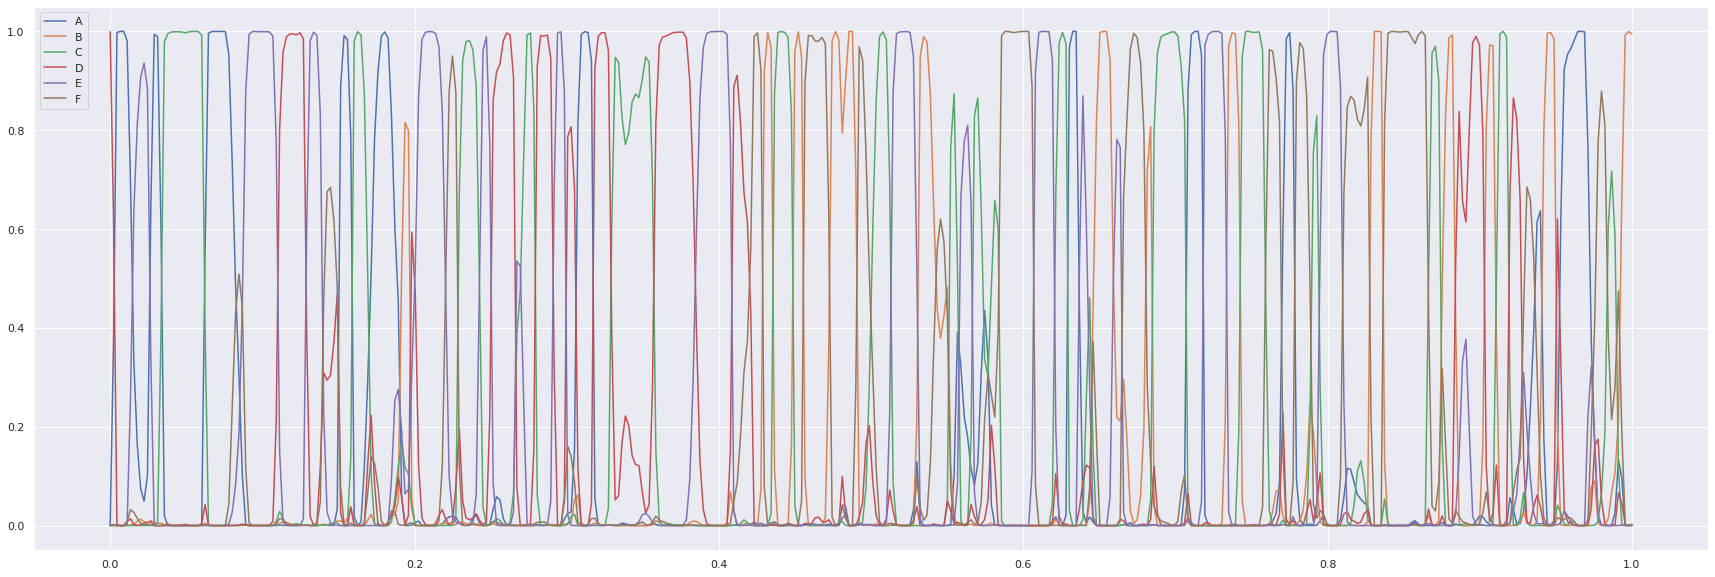

In [8]:
legands = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i in range(1):
    gamma_sub_list[0].shape
    x = np.linspace(0, 1, 450)
    sns.set()
    plt.figure(figsize=(30,10))
    plt.plot(x, gamma_sub_list[i])
    plt.legend(legands[:K_state], ncol=round(K_state/5), loc='upper left');

## Transition Matrix

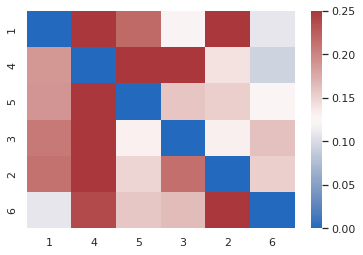

In [9]:
for cmap in ['vlag']:
    sns.heatmap(ordered_p,cmap=cmap,vmax=0.25 )
    plt.show()

##  FO Correlation Matrix

<AxesSubplot:>

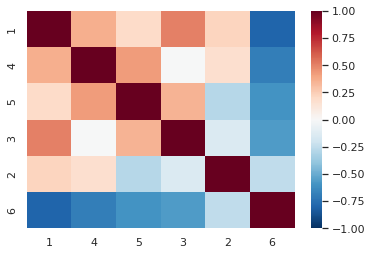

In [10]:
sns.heatmap(fo_corr,vmin=-1,cmap='RdBu_r')

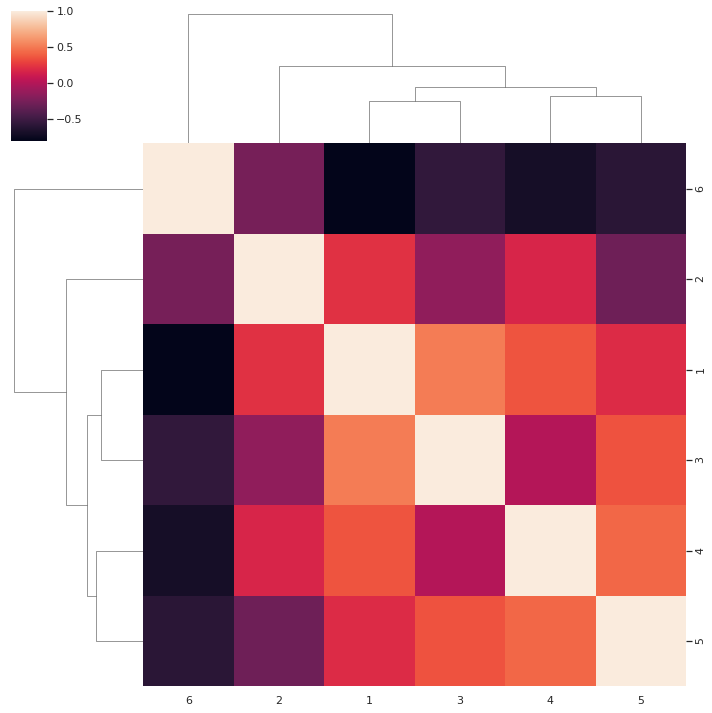

In [11]:
sns.clustermap(fo_corr)

# Meta states

In [12]:
from IPython.display import SVG
import numpy as np
import networkx as nx
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, modularity, bimodularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

In [13]:
G = nx.DiGraph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
for node in ordered_p.columns:
    for other_node in ordered_p.index:
        if node == other_node:
            continue
        G.add_weighted_edges_from([(node, other_node, ordered_p.loc[node,other_node])])

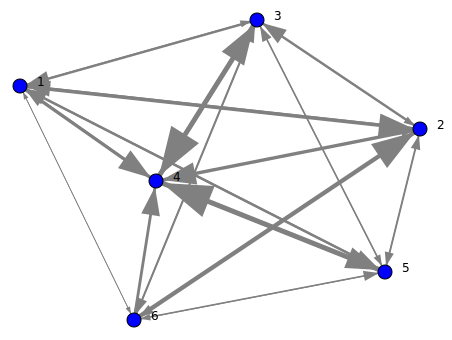

In [14]:
A= nx.to_scipy_sparse_matrix(G)
louvain = Louvain()
labels = louvain.fit_transform(A)
names = ordered_p.columns
image = svg_digraph(A,names=names, labels=labels)
SVG(image)

# Making Prediction with Chronnectome Feature

## Load Data

In [15]:
performance = pd.read_csv(f'{behav_dir}performance_proc.csv')
physio = pd.read_csv(f'{behav_dir}physio_proc.csv')
acti = pd.read_csv(f'{behav_dir}actigraph_proc.csv')
scales = pd.read_csv(f'{behav_dir}questionnaire_proc.csv')


In [16]:
fo_df =  pd.DataFrame(raw_fo, columns=[f'state{i}_fo' for i in range(1, K_state+1)])
lifetime_df = pd.DataFrame(get_mean_chronnectome(lifetime ), columns=[f'state{i}_life' for i in range(1, K_state+1)])
interval_df = pd.DataFrame(get_mean_chronnectome(intervals), columns=[f'state{i}_intervals' for i in range(1, K_state+1)])
visits_df = get_number_of_visit(lifetime)
visits_df.head()

,state1_visits,state2_visits,state3_visits,state4_visits,state5_visits,state6_visits
0,10,13,17,11,15,13
1,14,17,17,17,11,7
2,20,16,17,25,14,1
3,13,17,12,16,11,13
4,13,14,15,20,15,5


In [17]:
chronnectome_df = pd.concat([fo_df,lifetime_df, interval_df, visits_df], axis=1).applymap(lambda x: round(float(x),2))
chronnectome_df

,state1_fo,state2_fo,state3_fo,state4_fo,state5_fo,state6_fo,state1_life,state2_life,state3_life,state4_life,...,state3_intervals,state4_intervals,state5_intervals,state6_intervals,state1_visits,state2_visits,state3_visits,state4_visits,state5_visits,state6_visits
0,0.12,0.14,0.22,0.14,0.20,0.18,5.60,4.69,5.71,5.82,...,20.75,36.40,24.36,22.33,10.0,13.0,17.0,11.0,15.0,13.0
1,0.14,0.22,0.22,0.21,0.12,0.09,4.64,5.76,5.94,5.53,...,20.00,22.25,34.00,61.33,14.0,17.0,17.0,17.0,11.0,7.0
2,0.26,0.19,0.16,0.24,0.14,0.01,5.85,5.31,4.35,4.36,...,20.62,13.04,26.69,0.00,20.0,16.0,17.0,25.0,14.0,1.0
3,0.17,0.18,0.12,0.21,0.16,0.16,5.92,4.88,4.33,5.88,...,35.27,22.87,34.10,30.08,13.0,17.0,12.0,16.0,11.0,13.0
4,0.22,0.16,0.23,0.19,0.14,0.06,7.54,5.29,6.93,4.20,...,23.07,17.47,21.93,89.75,13.0,14.0,15.0,20.0,15.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.15,0.19,0.24,0.28,0.14,0.00,5.58,6.14,6.24,5.82,...,18.12,14.90,26.85,0.00,12.0,14.0,17.0,22.0,14.0,0.0
107,0.23,0.08,0.22,0.23,0.22,0.02,5.42,4.38,6.60,5.25,...,23.43,17.58,19.25,76.00,19.0,8.0,15.0,20.0,17.0,3.0
108,0.14,0.12,0.24,0.18,0.12,0.20,4.33,6.62,7.71,5.33,...,25.15,26.43,38.22,32.40,15.0,8.0,14.0,15.0,10.0,11.0
109,0.18,0.12,0.26,0.25,0.17,0.02,5.53,4.91,7.67,4.67,...,19.21,14.70,26.15,149.00,15.0,11.0,15.0,24.0,14.0,3.0


<AxesSubplot:>

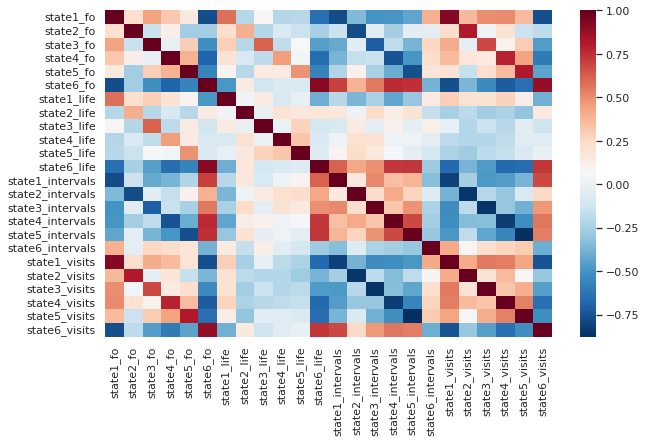

In [18]:
# FO matrix
plt.figure(figsize=(10,6))
sns.heatmap(chronnectome_df.corr(),cmap='RdBu_r')

## Label Encoding


In [19]:
# Chronotype Encoding
from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(performance[['Type']])
chrono_array = oe_results.toarray()[:,0]
chrono_array

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
# Session Encoding 
# ... do this in a better way
ses_list = []
for ses in [0, 1, 2]:
    ses_list += [ses for i in range(37)]
ses_array = np.array(ses_list)
ses_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

## KNN classifier

In [21]:
# run PCA on FO Matrix, compress FO to 2D
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

pca = decomposition.PCA(n_components=2)
chronnectome_df_reduced = pca.fit_transform(chronnectome_df)
dim1 = chronnectome_df_reduced[:,0]; dim2 = chronnectome_df_reduced[:,1]


In [25]:
cluster_df = pd.DataFrame([])
cluster_df['dim1'] = (dim1 - dim1.mean())/dim1.std()
cluster_df['dim2'] = (dim2 - dim2.mean())/dim2.std()
cluster_df['chro_type'] =  chrono_array 
cluster_df['time'] = ses_array
cluster_df

,dim1,dim2,chro_type,time
0,-0.513958,-0.074366,1.0,0
1,0.068531,-0.400307,1.0,0
2,-0.748952,-1.437465,1.0,0
3,-0.389537,-0.302596,1.0,0
4,0.481727,-0.363813,1.0,0
...,...,...,...,...
106,-0.775964,-0.996654,0.0,2
107,0.310499,-0.755446,0.0,2
108,-0.351163,-0.342028,0.0,2
109,1.321333,-0.078364,0.0,2


In [23]:
X = cluster_df[['dim1', 'dim2']].values
n_neighbors = 3

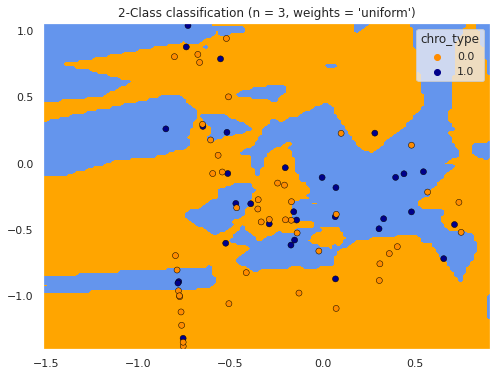

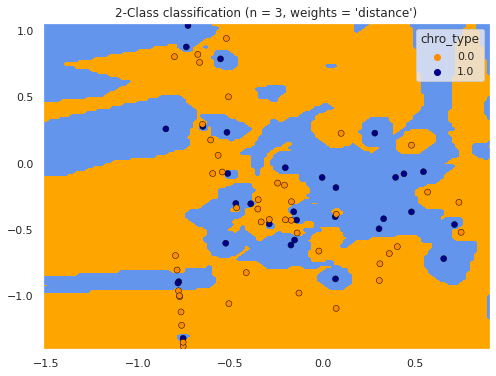

In [24]:
#KNN (N=3) Target=Chronotype
y = cluster_df.chro_type

# Create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(["orange", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]

warp_knn(X,y,n_neighbors, cmap_light, cmap_bold)
# E type as 1, L as 0


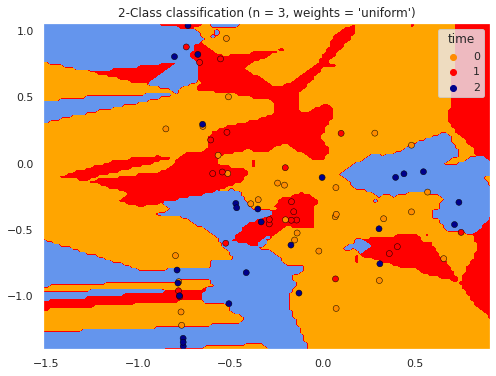

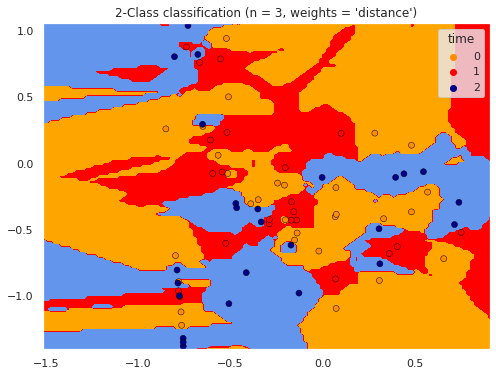

In [26]:
#KNN (N=3) Target=Time of day
y = cluster_df.time

from matplotlib.colors import ListedColormap
# Create color maps
cmap_light = ListedColormap(["orange","red", "cornflowerblue"])
cmap_bold = ["darkorange", "red","darkblue"]

warp_knn(X,y,n_neighbors, cmap_light, cmap_bold)
# 0 M ; 1 A; 2 E

## Logistic Regression 

In [ ]:
fo['chronotype']=chrono_array
fo['time'] = ses_array

In [ ]:
fo.to_csv(f'fo_target_K{K_state}.csv')


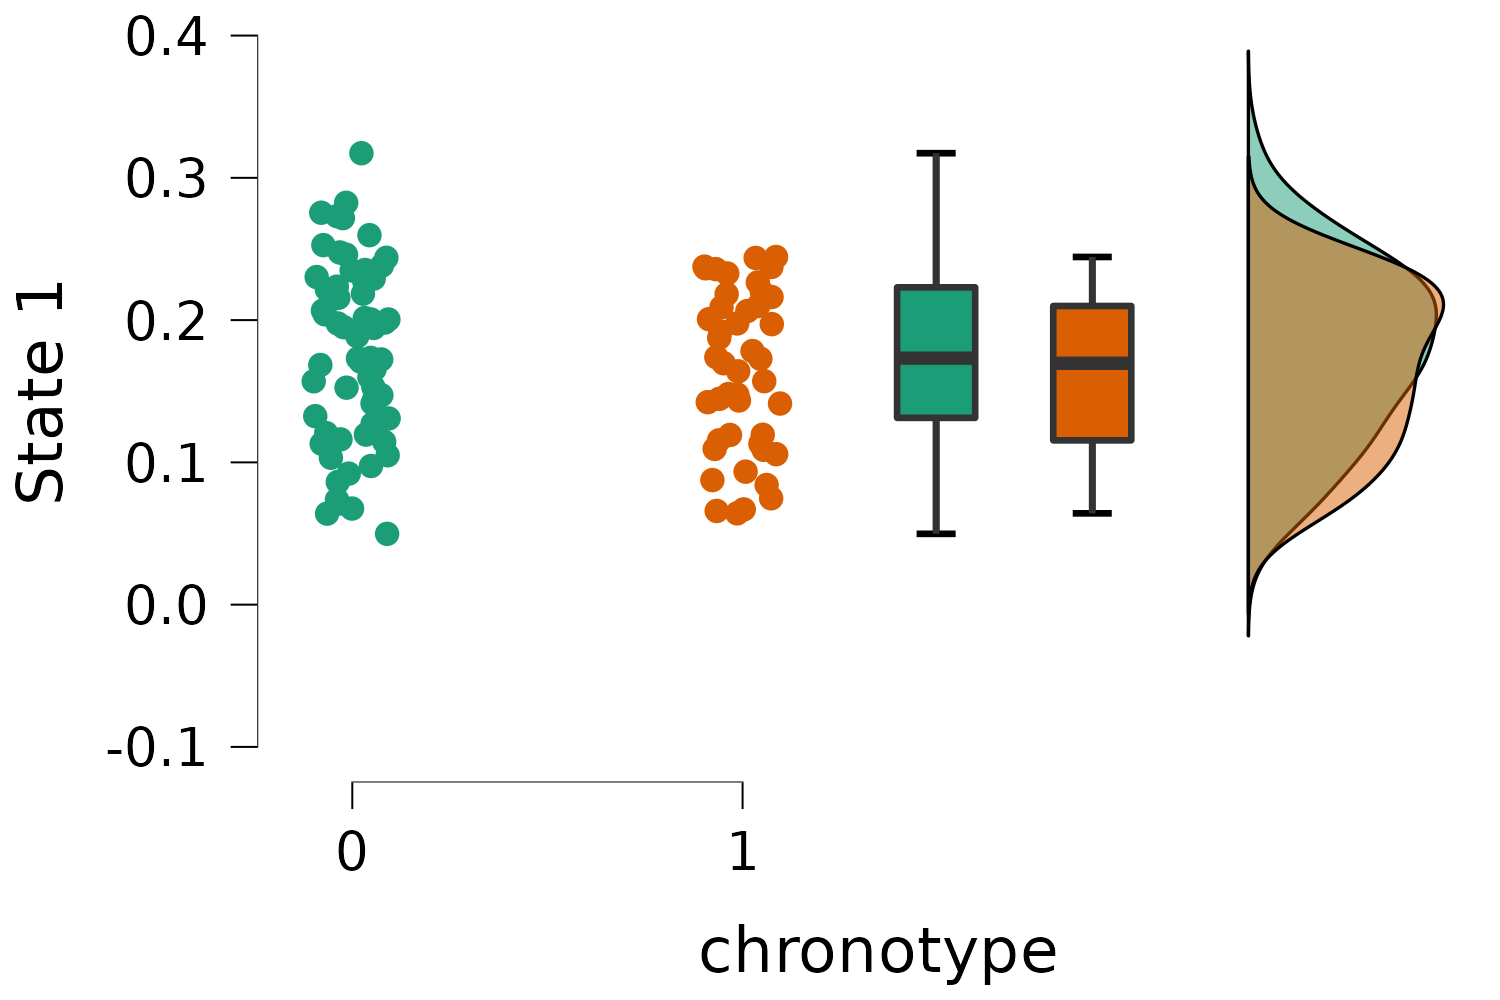
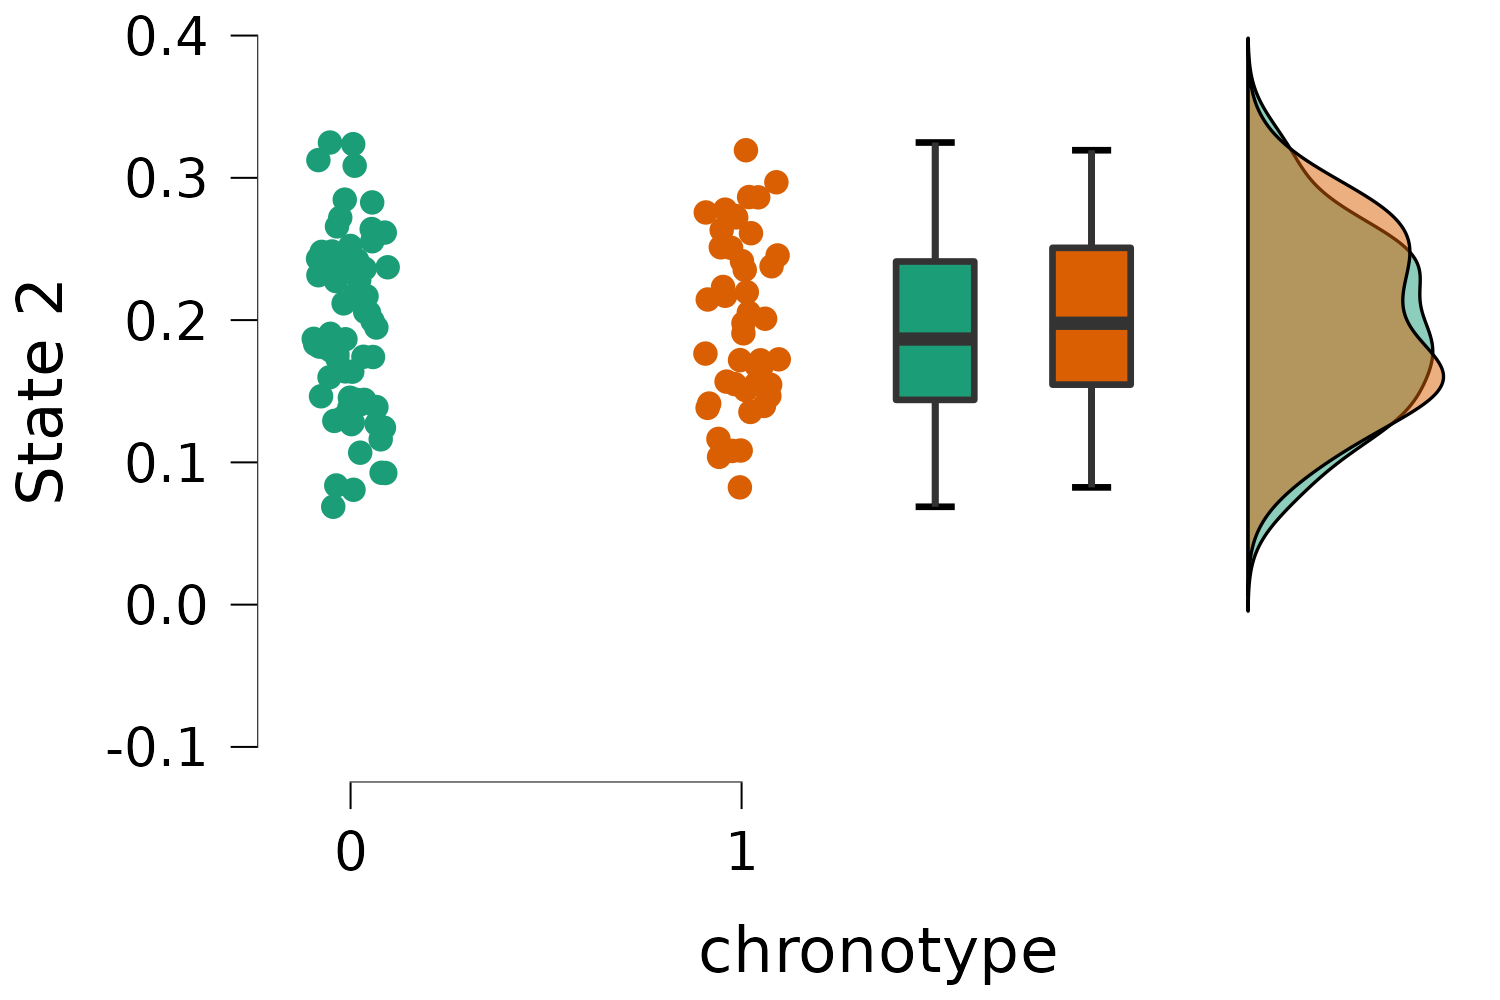
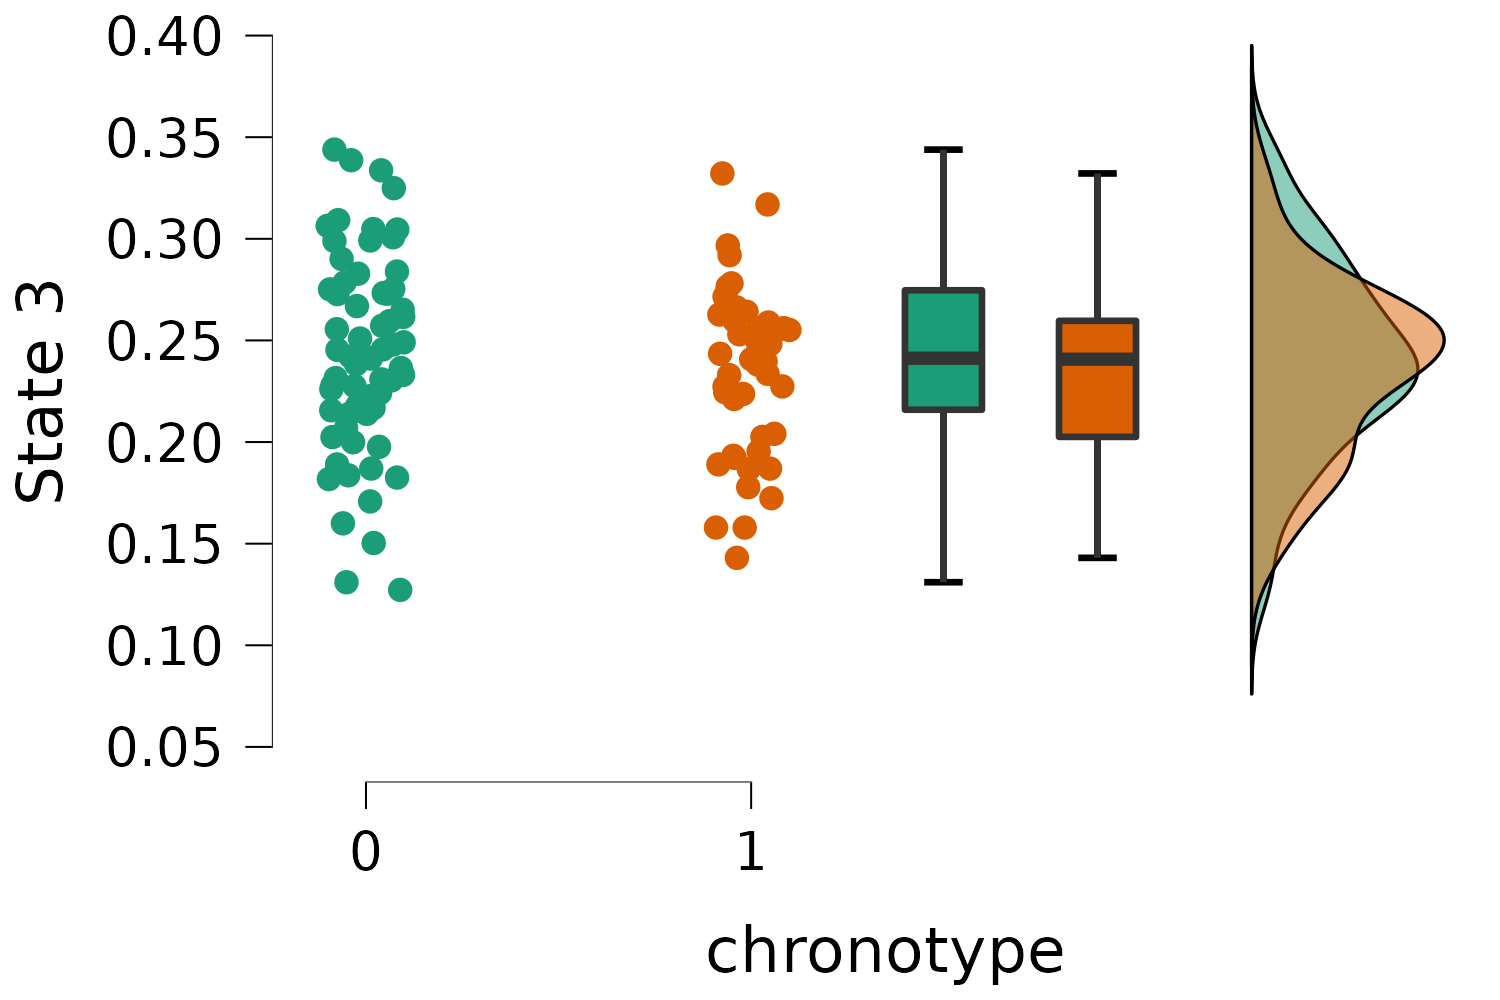
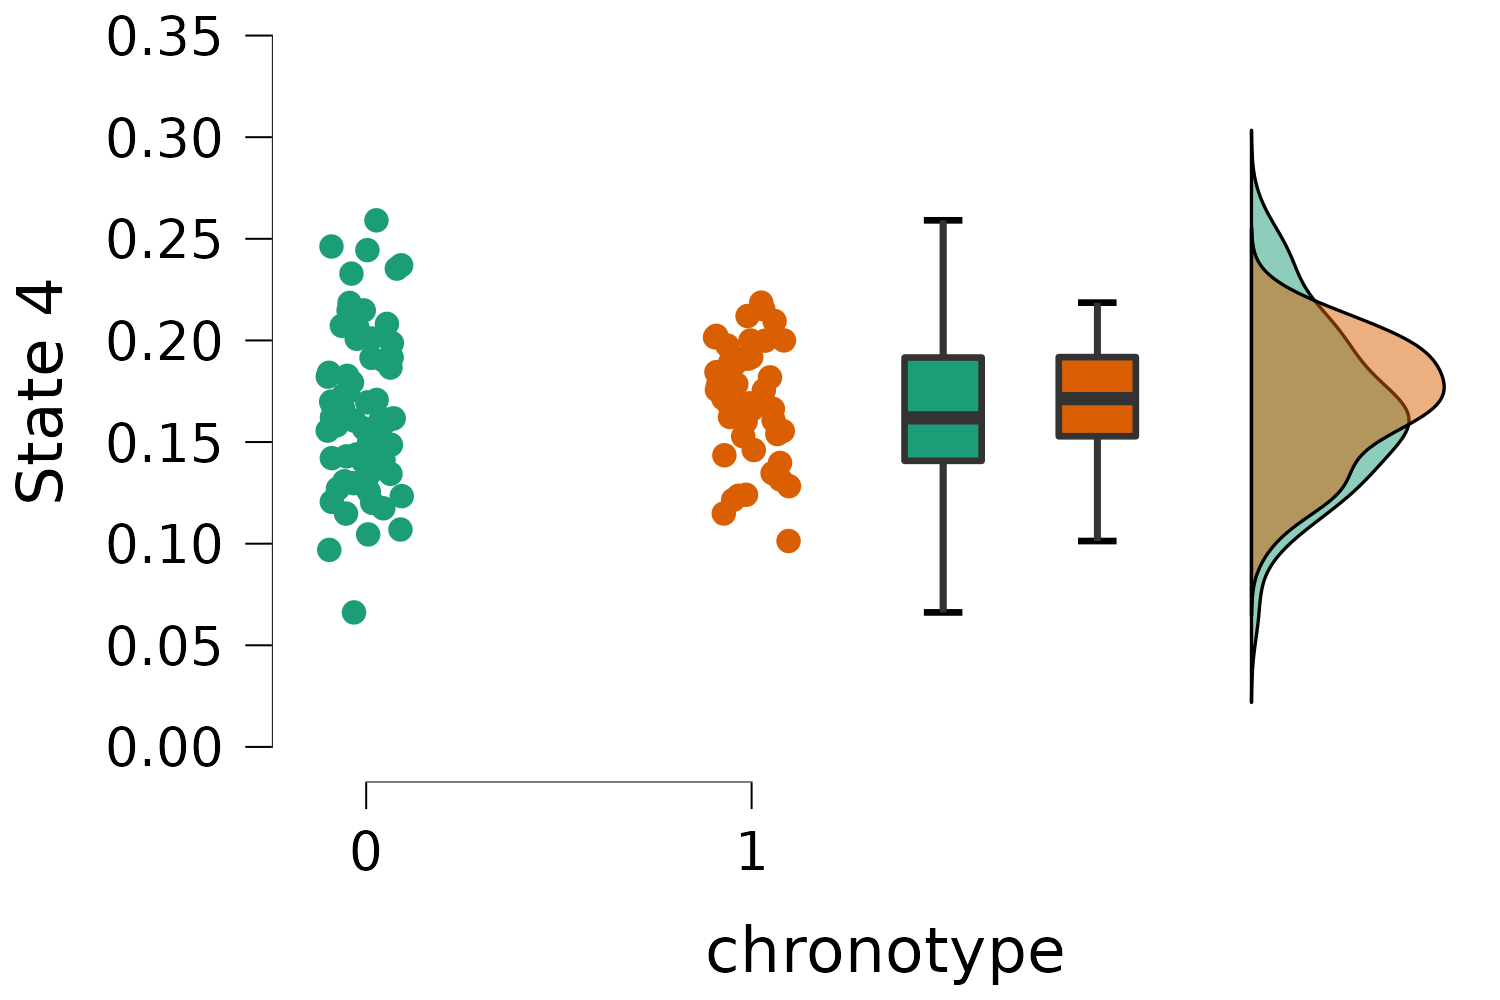
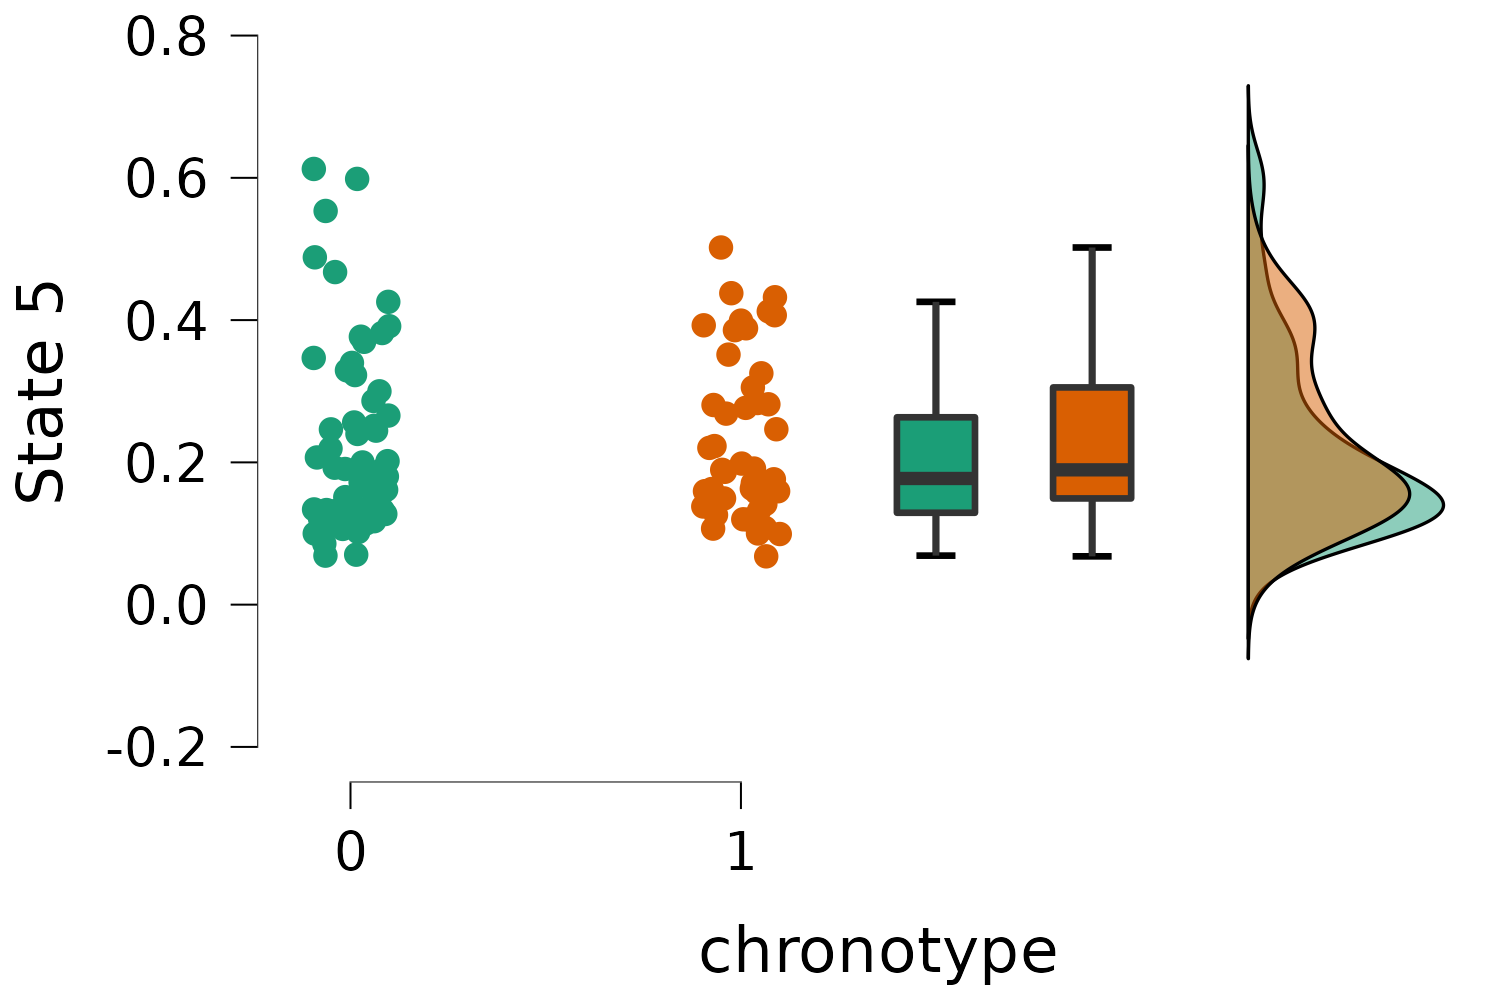
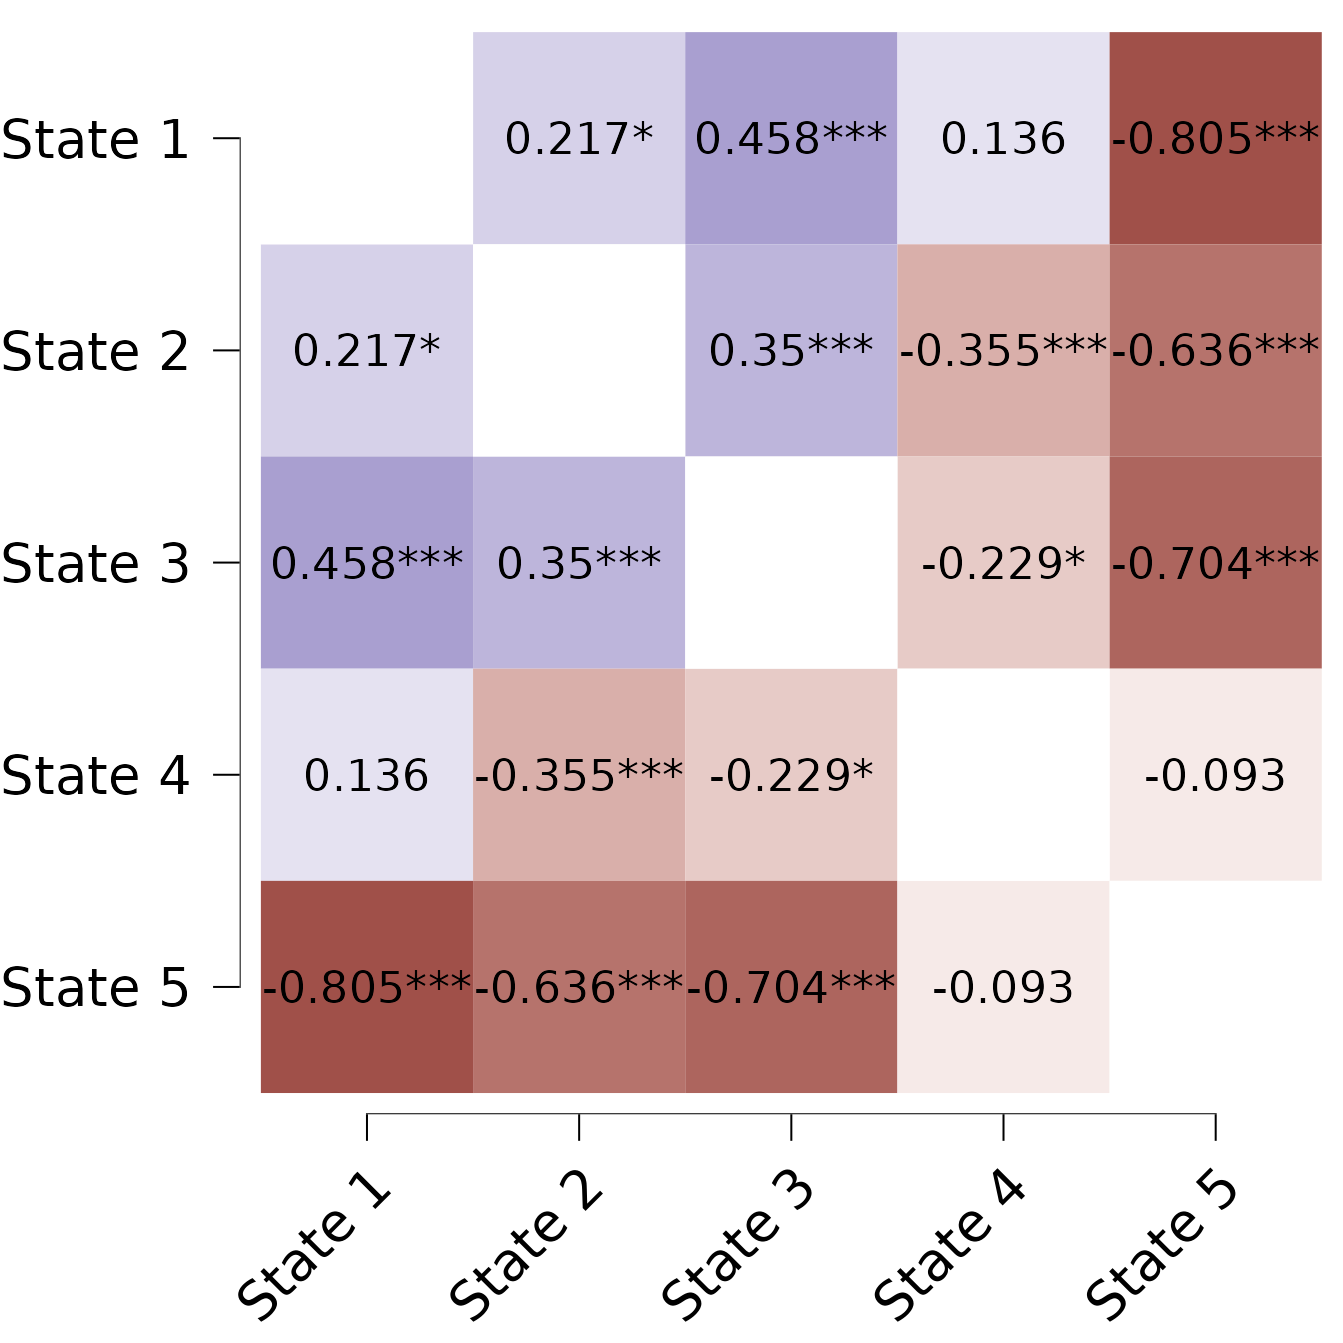
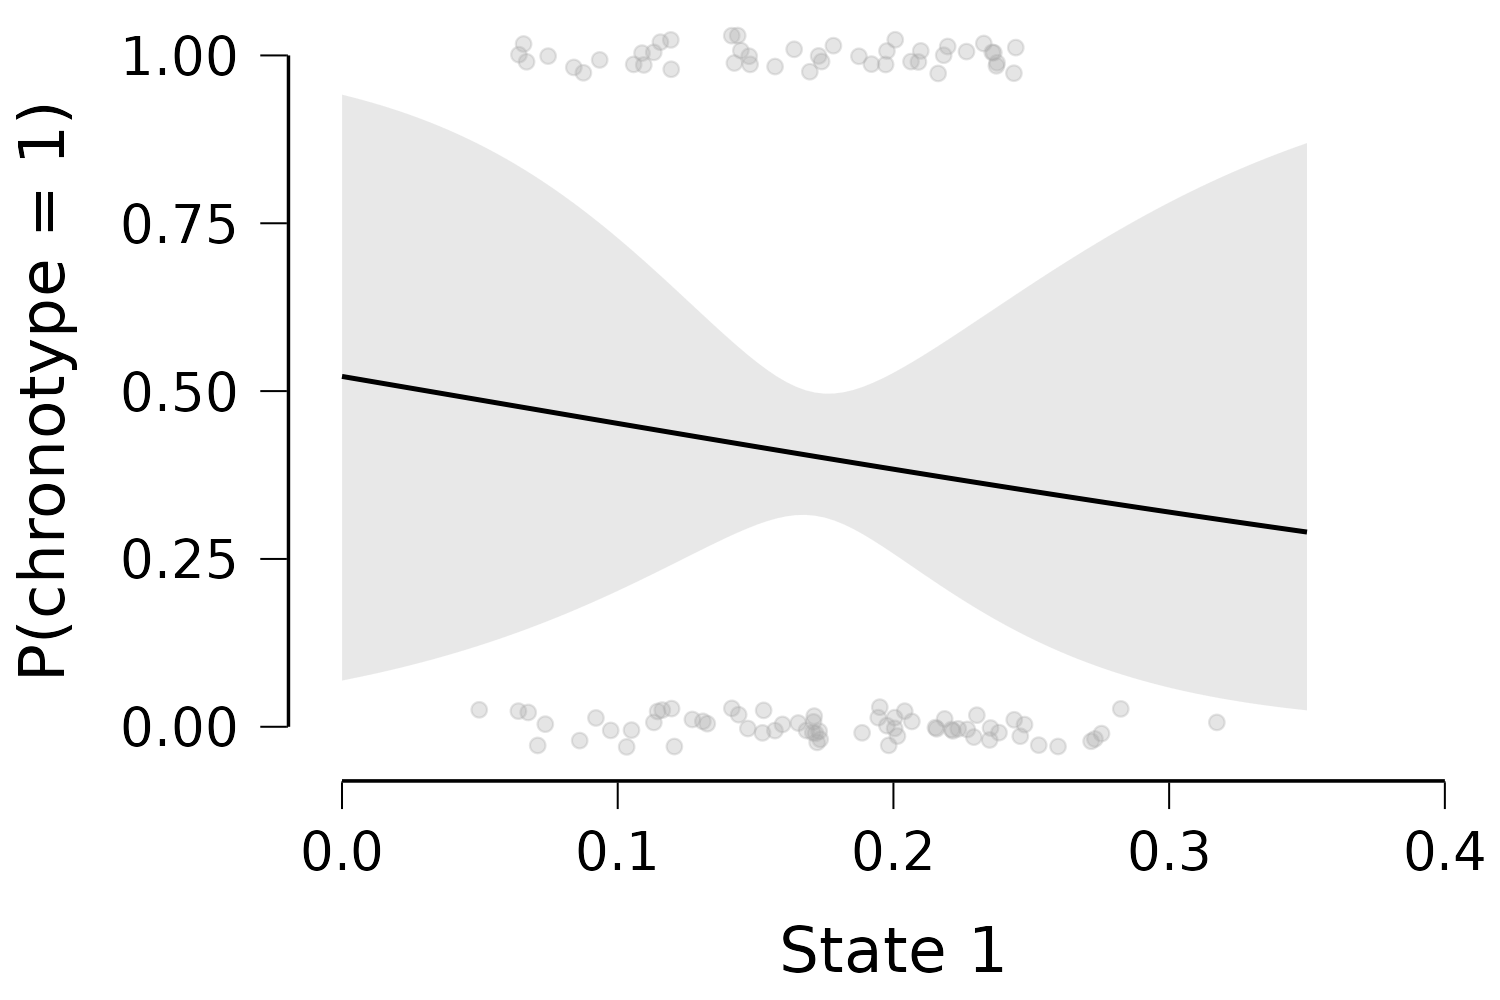
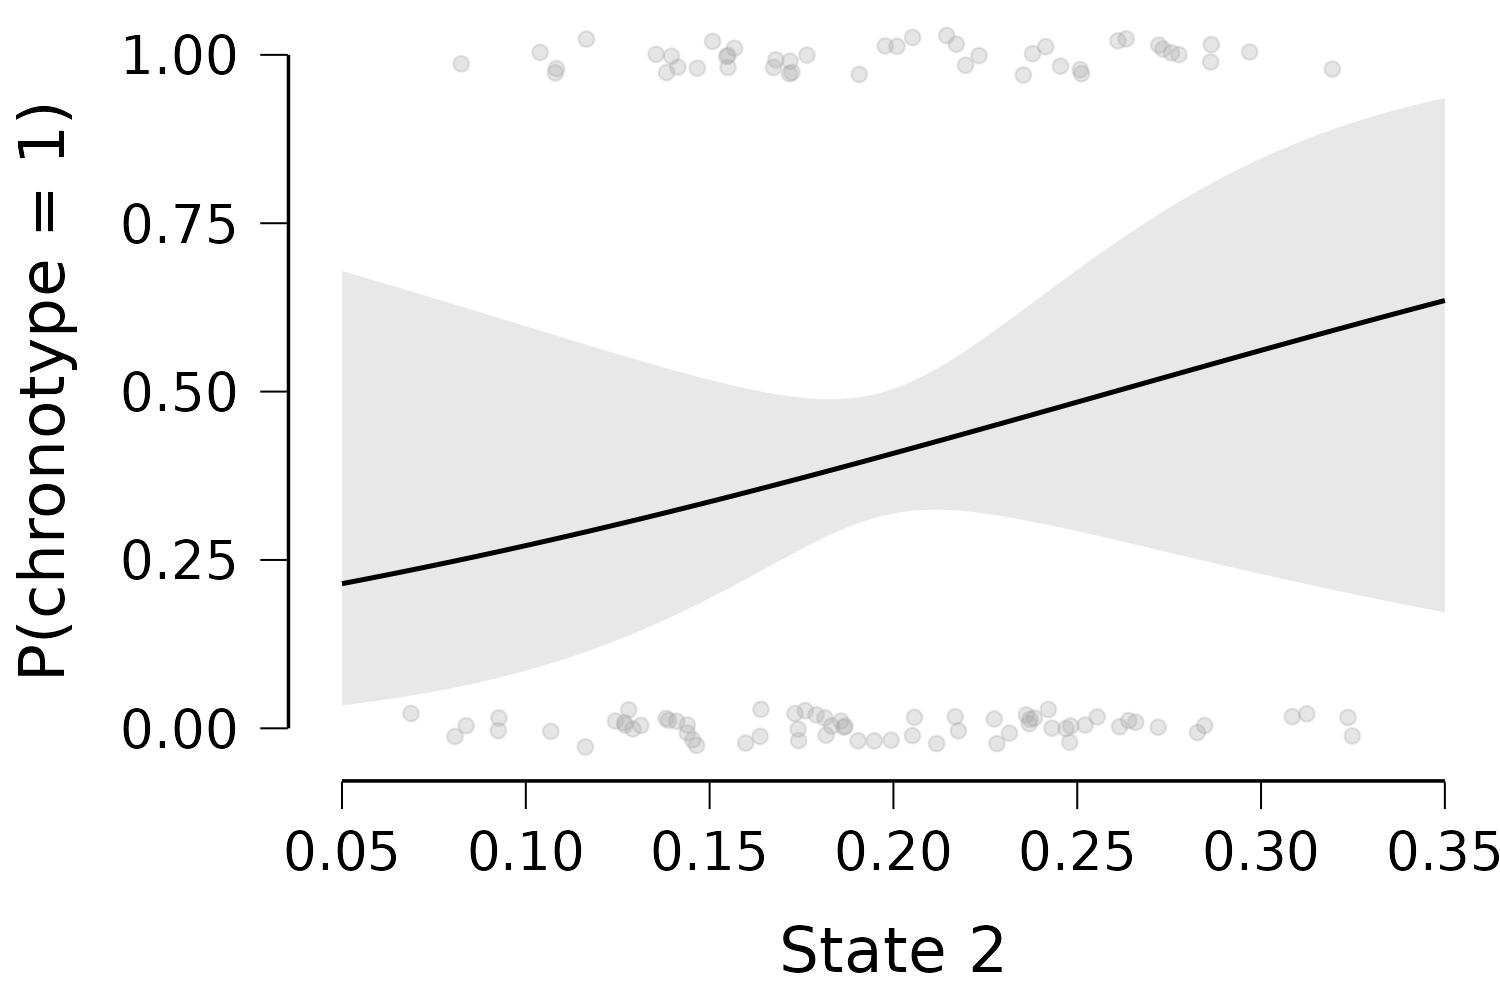
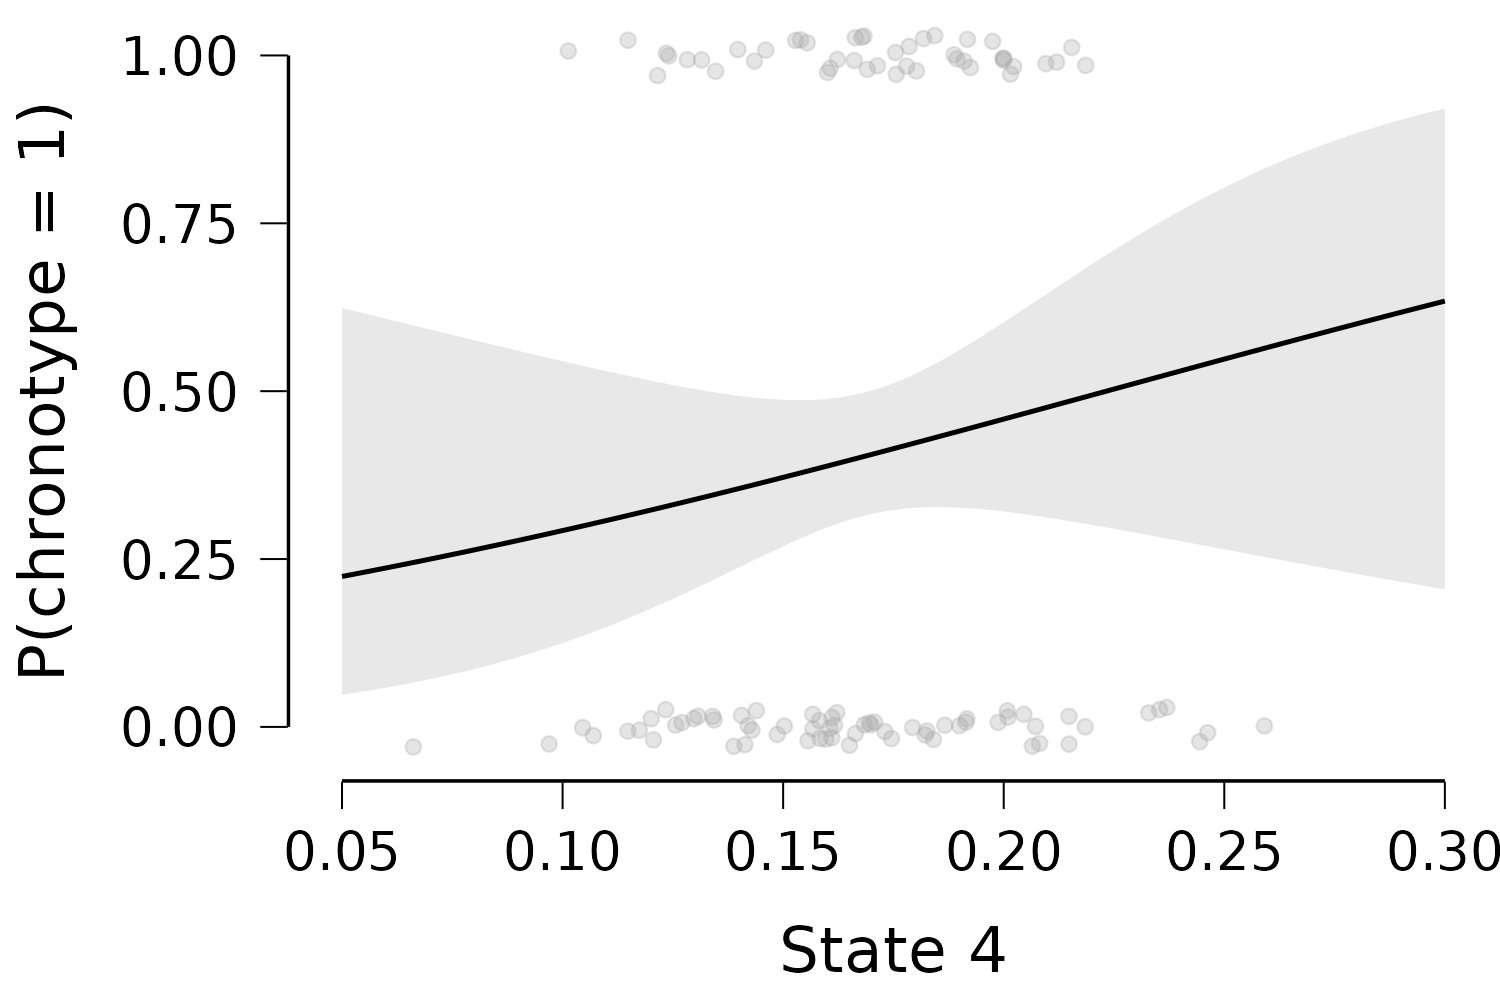
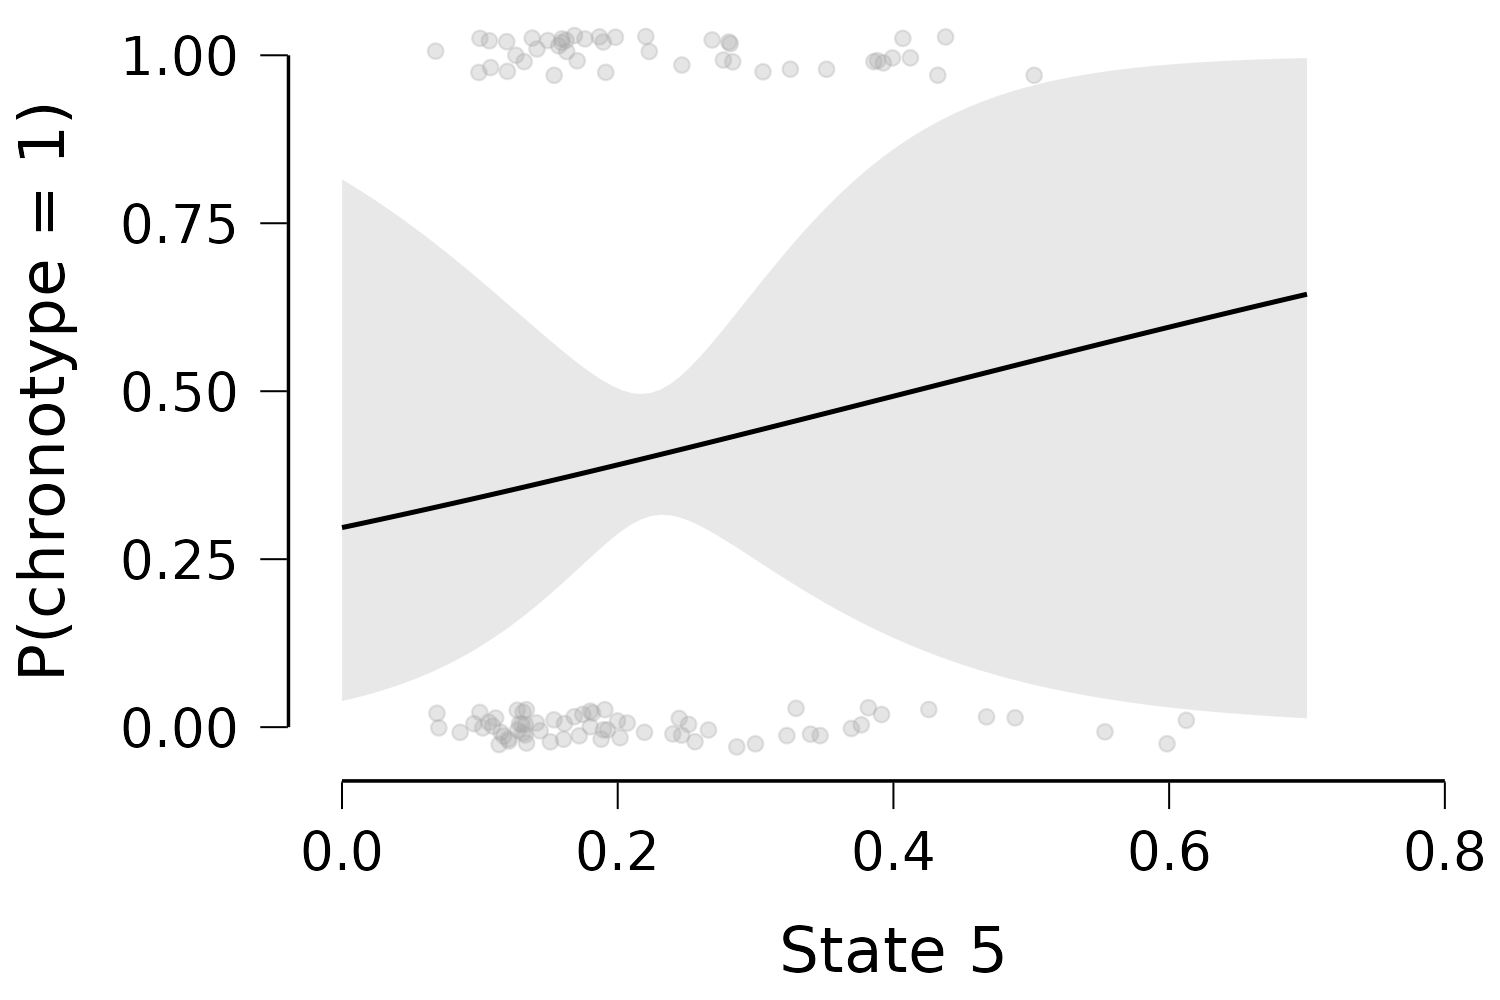

In [ ]:
from IPython.display import HTML
file = f'drive/MyDrive/HMM/jasp/jasp_k{K_state}_r{rep_num}.html'
HTML(filename=file)

## Correlation

In [31]:
fo = fo_df.copy()
fo['chrono']=chrono_array; fo['time']=ses_array


In [32]:
fo

,state1_fo,state2_fo,state3_fo,state4_fo,state5_fo,state6_fo,chrono,time
0,0.124444,0.135556,0.215556,0.142222,0.204444,0.177778,1.0,0
1,0.144444,0.217778,0.224444,0.208889,0.117778,0.086667,1.0,0
2,0.260000,0.188889,0.164444,0.242222,0.137778,0.006667,1.0,0
3,0.171111,0.184444,0.115556,0.208889,0.157778,0.162222,1.0,0
4,0.217778,0.164444,0.231111,0.186667,0.135556,0.064444,1.0,0
...,...,...,...,...,...,...,...,...
106,0.148889,0.191111,0.235556,0.284444,0.140000,0.000000,0.0,2
107,0.228889,0.077778,0.220000,0.233333,0.224444,0.015556,0.0,2
108,0.144444,0.117778,0.240000,0.177778,0.124444,0.195556,0.0,2
109,0.184444,0.120000,0.255556,0.248889,0.166667,0.024444,0.0,2


In [33]:
# fo['Type'] = oe_results.toarray()[:,0] # E type as 1, L as 0
fo_m = fo[fo['time']==0] ;fo_a = fo[fo['time']==1].reset_index(drop=True) 
fo_e = fo[fo['time']==2].reset_index(drop=True)
fo.head()

,state1_fo,state2_fo,state3_fo,state4_fo,state5_fo,state6_fo,chrono,time
0,0.124444,0.135556,0.215556,0.142222,0.204444,0.177778,1.0,0
1,0.144444,0.217778,0.224444,0.208889,0.117778,0.086667,1.0,0
2,0.260000,0.188889,0.164444,0.242222,0.137778,0.006667,1.0,0
3,0.171111,0.184444,0.115556,0.208889,0.157778,0.162222,1.0,0
4,0.217778,0.164444,0.231111,0.186667,0.135556,0.064444,1.0,0


### Task Performance 

<AxesSubplot:>

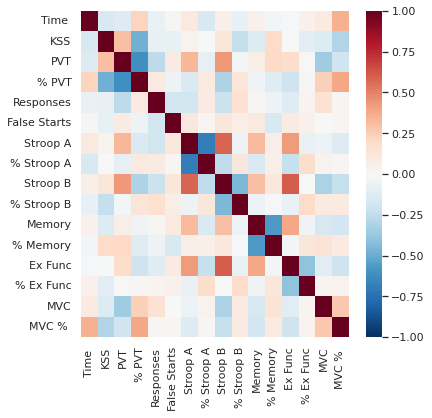

In [34]:
plt.figure(figsize=(6,6))
sns.heatmap(performance.iloc[:,2:].corr(), cmap="RdBu_r", vmin=-1)

In [35]:
per_a = performance[performance['TOD']=='A'].iloc[:,2:] ; per_m = performance[performance['TOD']=='M'].iloc[:,2:]
per_e = performance[performance['TOD']=='E'].iloc[:,2:] 
per_mae = pd.concat([per_m, per_a, per_e], axis=0).reset_index(drop=True)
per_mae

,TOD,Time,KSS,PVT,% PVT,Responses,False Starts,Stroop A,% Stroop A,Stroop B,% Stroop B,Memory,% Memory,Ex Func,% Ex Func,MVC,MVC %
0,M,8.42,3.0,0.37,94.72,32.0,4.0,0.91,100.00,0.94,100.00,4.57,80.15,81.36,100.00,51.5,89.57
1,M,8.77,3.0,0.35,95.37,33.0,1.0,0.83,100.00,1.11,97.25,5.87,66.28,86.77,100.00,40.2,84.63
2,M,8.89,2.0,0.42,82.93,27.0,6.0,0.94,100.00,1.08,100.00,5.07,78.41,88.67,100.00,40.8,100.00
3,M,8.58,3.0,0.35,95.97,32.0,0.0,0.84,94.50,0.95,100.00,4.87,100.00,84.35,95.09,38.7,100.00
4,M,8.64,4.0,0.40,99.78,34.0,0.0,1.10,100.00,1.33,100.00,5.63,88.27,91.61,97.49,40.8,97.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,E,20.58,4.0,0.52,99.79,27.0,0.0,0.92,100.00,1.40,90.27,4.22,92.74,73.79,99.21,22.6,97.00
107,E,20.54,5.0,0.41,97.56,29.0,1.0,1.14,84.22,1.22,67.95,7.14,83.53,77.29,100.00,29.0,98.64
108,E,20.65,4.0,0.34,100.00,29.0,1.0,0.96,100.00,1.04,98.65,4.92,79.96,85.71,97.19,64.6,100.00
109,E,20.51,3.0,0.35,100.00,29.0,1.0,1.09,68.79,0.94,91.67,4.30,76.43,69.27,100.00,46.8,100.00


In [36]:
df_fo_perform = pd.concat([fo, per_mae], axis=1)
df_fo_perform.head()

,state1_fo,state2_fo,state3_fo,state4_fo,state5_fo,state6_fo,chrono,time,TOD,Time,...,Stroop A,% Stroop A,Stroop B,% Stroop B,Memory,% Memory,Ex Func,% Ex Func,MVC,MVC %
0,0.124444,0.135556,0.215556,0.142222,0.204444,0.177778,1.0,0,M,8.42,...,0.91,100.0,0.94,100.00,4.57,80.15,81.36,100.00,51.5,89.57
1,0.144444,0.217778,0.224444,0.208889,0.117778,0.086667,1.0,0,M,8.77,...,0.83,100.0,1.11,97.25,5.87,66.28,86.77,100.00,40.2,84.63
2,0.260000,0.188889,0.164444,0.242222,0.137778,0.006667,1.0,0,M,8.89,...,0.94,100.0,1.08,100.00,5.07,78.41,88.67,100.00,40.8,100.00
3,0.171111,0.184444,0.115556,0.208889,0.157778,0.162222,1.0,0,M,8.58,...,0.84,94.5,0.95,100.00,4.87,100.00,84.35,95.09,38.7,100.00
4,0.217778,0.164444,0.231111,0.186667,0.135556,0.064444,1.0,0,M,8.64,...,1.10,100.0,1.33,100.00,5.63,88.27,91.61,97.49,40.8,97.84


In [37]:
def warp_focorr_plot(df_concat,figsize=(8,8), cmap="RdBu_r", vmin=-0.6, vmax=0.6,abs=False, K_state=K_state):
    if abs:
        corr_matrix = abs(df_concat.corr())
        cmap = 'Reds'
    else:
        corr_matrix = df_concat.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix.iloc[:K_state,K_state:], vmin=vmin,vmax=vmax, cmap=cmap)

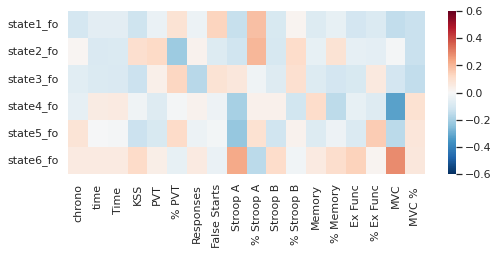

In [38]:
warp_focorr_plot(df_fo_perform, (8,3))

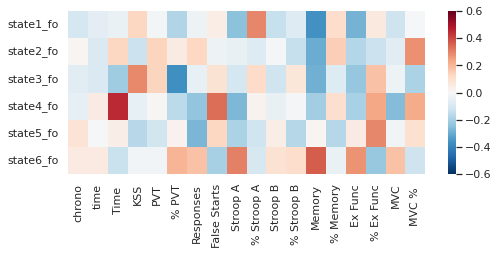

In [39]:
warp_focorr_plot(pd.concat([fo,per_m], axis=1), (8,3))

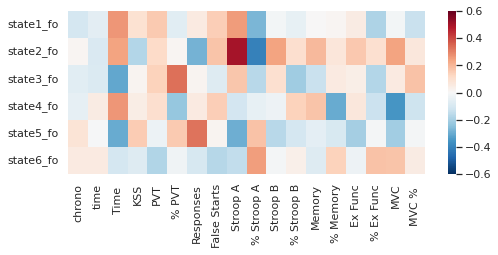

In [40]:
warp_focorr_plot(pd.concat([fo,per_a], axis=1), (8,3))

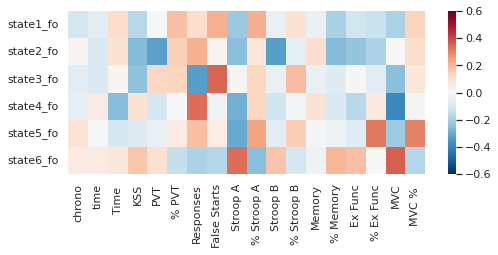

In [41]:
warp_focorr_plot(pd.concat([fo,per_e], axis=1), (8,3))

### Other behavior

In [42]:
def creat_corrdf(fo_tod):
    return pd.concat([fo_tod,physio, acti, scales], axis=1).drop(['ID No.', 'Unnamed: 3','Unnamed: 8','Unnamed: 18','Unnamed: 20',],axis=1)

fo_m_beh = creat_corrdf(fo_m) ; fo_a_beh = creat_corrdf(fo_a); fo_e_beh = creat_corrdf(fo_e)
fo_beh_list = [fo_m_beh, fo_a_beh, fo_e_beh]
fo_m_beh.columns

Index(['state1_fo', 'state2_fo', 'state3_fo', 'state4_fo', 'state5_fo',
       'state6_fo', 'chrono', 'time', 'Category', 'PER3', 'DLMO',
       'Phase Angle', 'Peak  Time', 'Peak Conc', 'Cor  Time', 'Cor Conc',
       'CAR %', 'AUC Total', 'AUC 1st Hour', 'Category', 'Days', 'Bed time',
       'Get up time', 'Time in bed', 'Sleep start', 'Sleep end',
       'Assumed sleep', 'Actual sleep time', 'Actual sleep (%)',
       'Actual wake time', 'Actual wake (%)', 'Sleep efficiency',
       'Sleep latency', 'Total activity score', 'Mean activity score',
       'Mean score in active periods', 'Fragmentation index',
       'Avg wake movement', 'IS', 'IV', 'L5', 'L5-onset-phase', 'M10',
       'M10-onset-phase', 'AMP', 'RA', '%OB>IBM', '%IB<OBM', 'Category',
       'Gender', 'Age', 'Handedness ', 'Height', 'Weight', 'Ethnic Origin',
       'MSFsc', 'PSQI', 'POMS', 'ESS', 'DEPRESSION', 'ANXIETY', 'STRESS',
       'DASS', 'BREAKFAST', 'WD'],
      dtype='object')

In [43]:
def warp_focorr_plot(df_concat,figsize=(8,8), cmap="RdBu_r", vmin=-0.6, vmax=0.6,absl=False, K_state=K_state):
    if absl:
        corr_matrix = abs(df_concat.corr())
        cmap = 'Reds'
    else:
        corr_matrix = df_concat.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix.iloc[:K_state,K_state:], vmin=vmin,vmax=vmax, cmap=cmap)

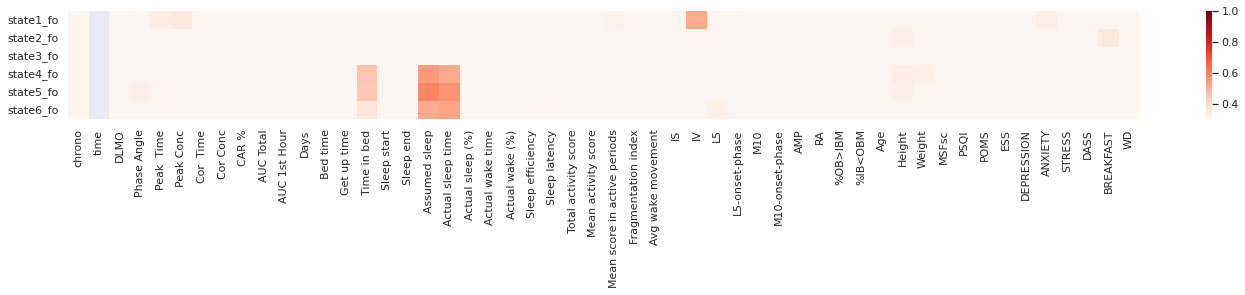

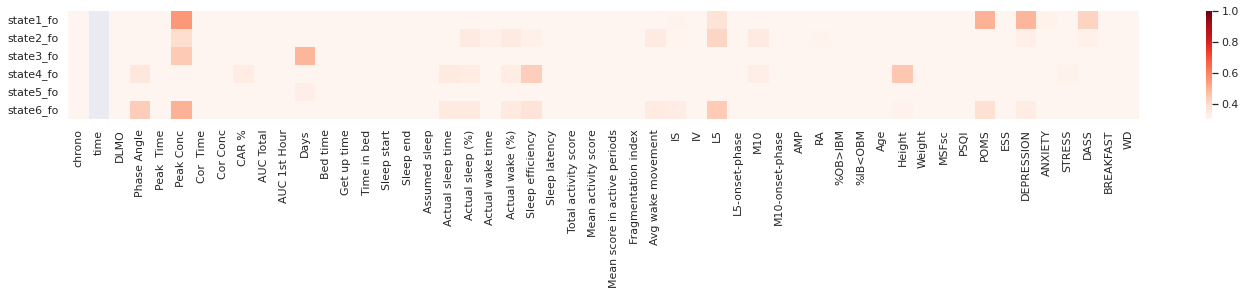

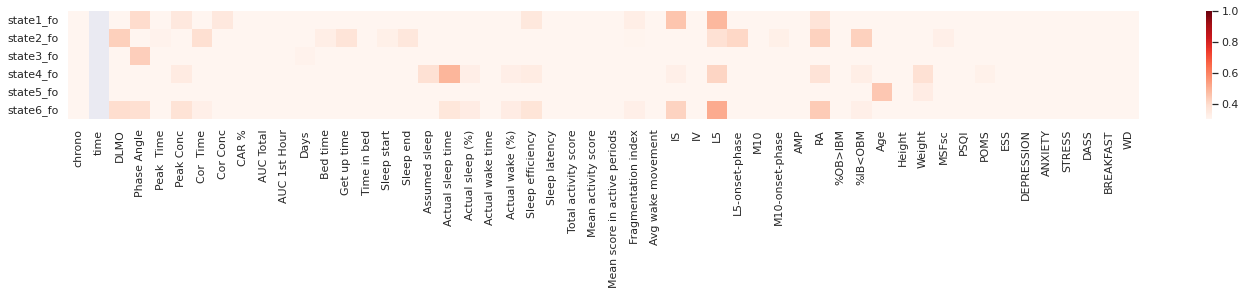

In [44]:
for df in fo_beh_list:
    warp_focorr_plot( df,(24,K_state/3), absl=True, vmin=0.3, vmax=1)

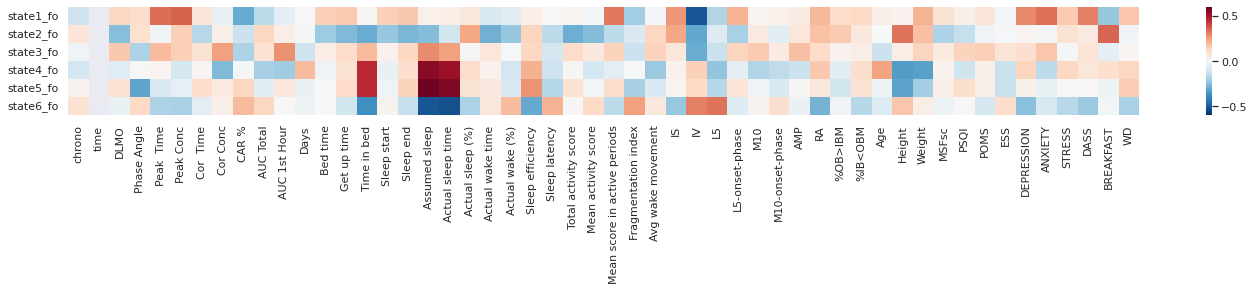

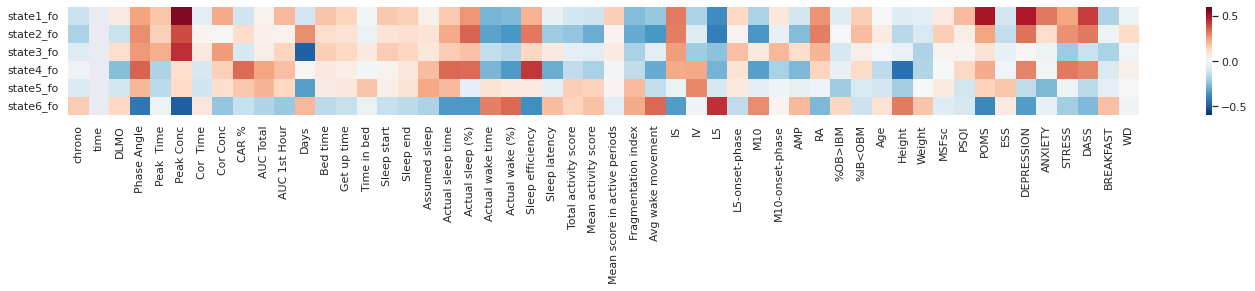

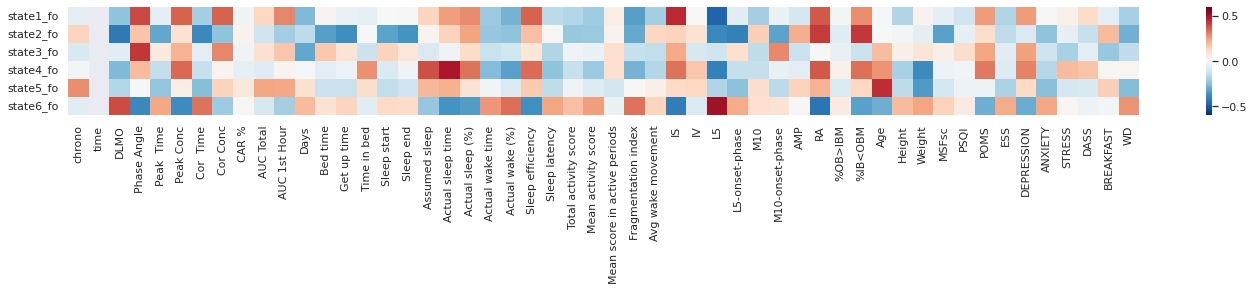

In [45]:
for df in fo_beh_list:
    warp_focorr_plot( df,(24,K_state/3))

<AxesSubplot:>

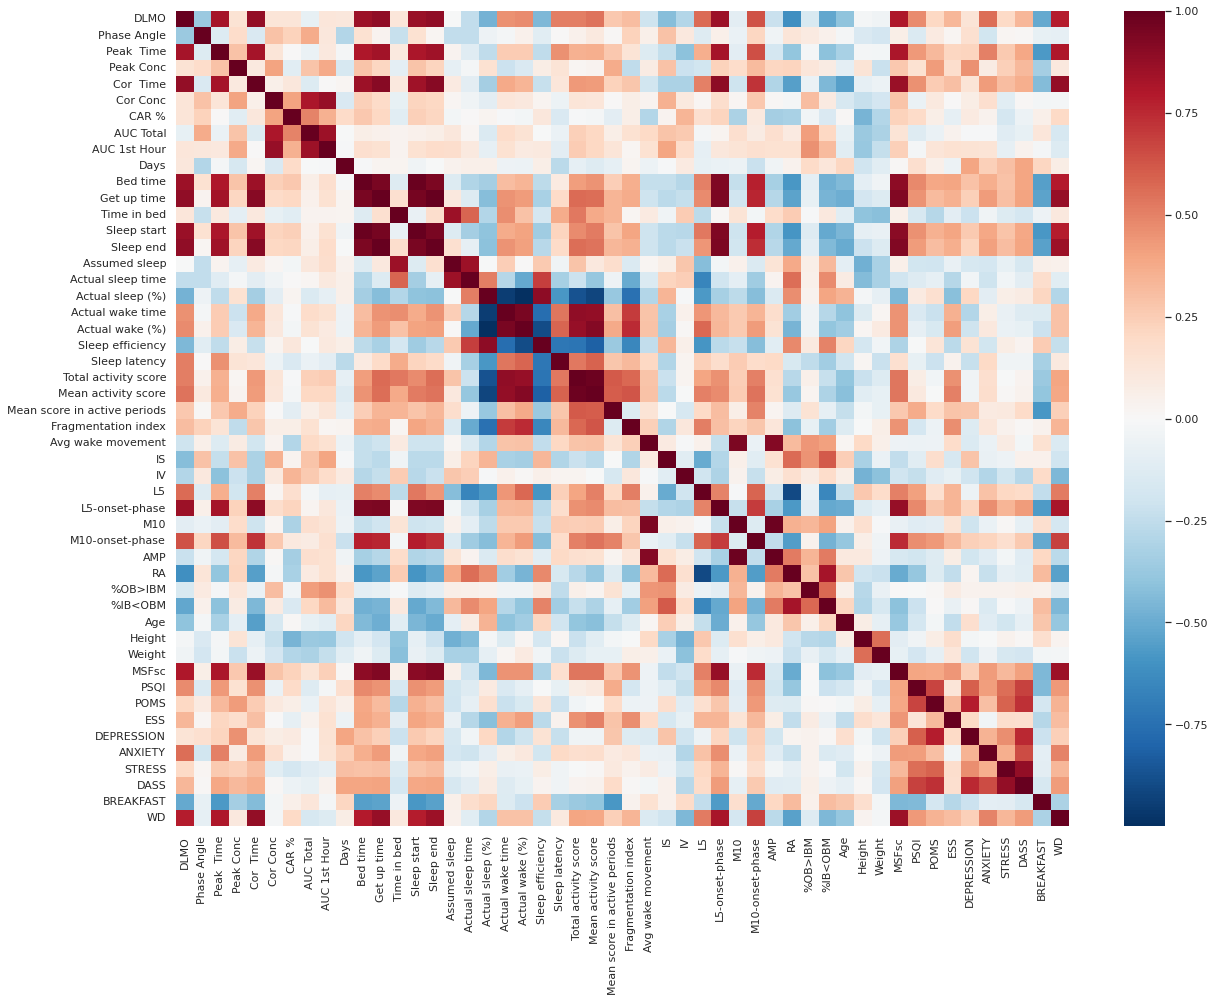

In [46]:
sleep_features = pd.concat([physio, acti, scales], axis=1).drop(['ID No.', 'Category', 'Unnamed: 3', 'Unnamed: 8', 'Unnamed: 18','Unnamed: 20'], axis=1 )
plt.figure(figsize=(20,15))
sns.heatmap(sleep_features.corr(), cmap='RdBu_r')


### States FO & Sleep Time Regplot
Session 0 -> Morning

Session 1 -> Afternoon

Session 2 -> Evening

<AxesSubplot:xlabel='state1_fo', ylabel='Assumed sleep'>

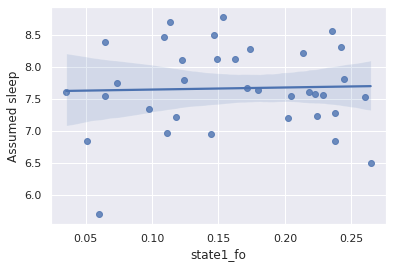

In [49]:
df = pd.concat([fo_beh_list[0],fo_beh_list[1],fo_beh_list[2]]).reset_index(drop=True)
df= df[df['time']==0]
sns.regplot(x="state1_fo", y='Assumed sleep', data=df )

In [50]:
def compare_r(feature, fo_beh_list=fo_beh_list, title=""):
    df_r = pd.DataFrame([], columns=['TOD', 'r_value'])
    for i, fo_matrix in enumerate(fo_beh_list):  
        corr_matrix = fo_matrix.corr().iloc[:K_state,K_state:]
        df_tmp = pd.DataFrame([], columns=['TOD'])
        df_tmp.iloc[:,0] = [i for k in range(K_state)]
        df_tmp['r_value'] = corr_matrix[feature].values
        df_r = pd.concat([df_r, df_tmp])
    df_r.reset_index(inplace=True)
    sns.barplot(x='index', y='r_value',hue='TOD', data=df_r)
    plt.show()
# Plot each session seperately
def ordered_sep_regplot_warp(feature, fo_beh_list, subplot_num=9, subplot_set=(3,3),figsize=(15,12), title=""):
    for i, fo_matrix in enumerate(fo_beh_list):  
        print(f"session {i}")
        corr_matrix = fo_matrix.corr().iloc[:K_state,K_state:]
        state_list = abs(corr_matrix[feature]
                ).sort_values(ascending=False).index[:subplot_num]
        plt.figure(figsize=figsize)
        plt.title(title)
        for i in range(len(state_list)):
            ax = plt.subplot(subplot_set[0],subplot_set[1],i+1)
            plt.tight_layout()
            sns.regplot(x=state_list[i],y=feature,data=fo_matrix,ax=ax)
        plt.show()

def lmplot_warp(feature, fo_beh_list, subplot_num=9, subplot_set=(3,3),figsize=(15,12), title=""):
    """
    use sns.lmplot to plot them together. 
    """
    fo_beh_conc = pd.concat([fo_beh_list[0],fo_beh_list[1],fo_beh_list[2]]).reset_index(drop=True)
    for i in range(K_state):
        plt.tight_layout()
        sns.lmplot(x=f"state{i+1}_fo", y=feature, hue='time', data=fo_beh_conc)
        plt.show()


def warp_regplot(feature, fo_beh_list=fo_beh_list, sep_plot=False,subplot_num=9, subplot_set=(3,3),figsize=(15,12), title=""):
    compare_r(feature,fo_beh_list)
    if sep_plot:
        ordered_sep_regplot_warp(feature, fo_beh_list, subplot_num, subplot_set,figsize, title)
    else:        
        lmplot_warp(feature, fo_beh_list, subplot_num, subplot_set,figsize, title)


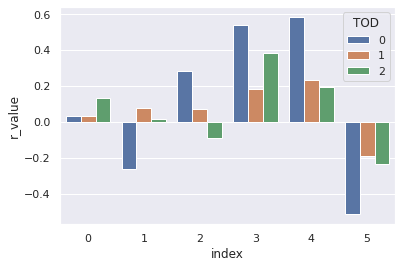

<Figure size 432x288 with 0 Axes>

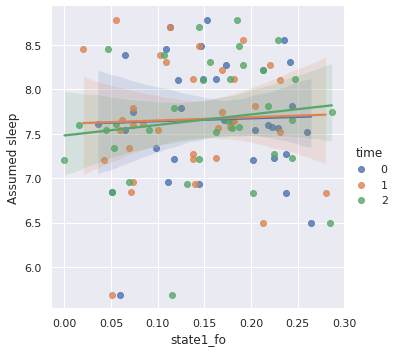

<Figure size 432x288 with 0 Axes>

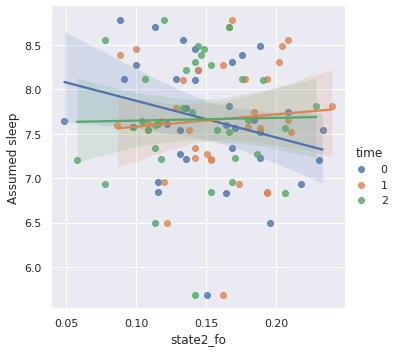

<Figure size 432x288 with 0 Axes>

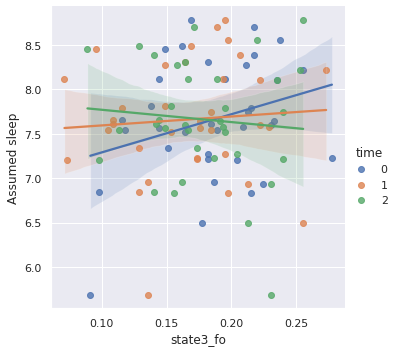

<Figure size 432x288 with 0 Axes>

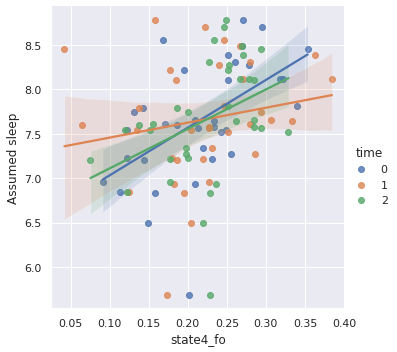

<Figure size 432x288 with 0 Axes>

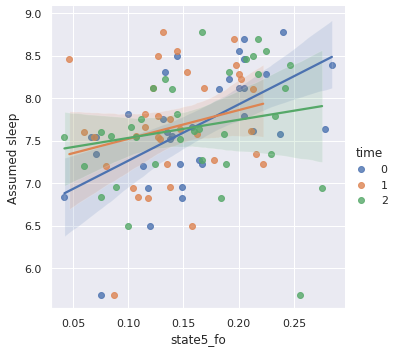

<Figure size 432x288 with 0 Axes>

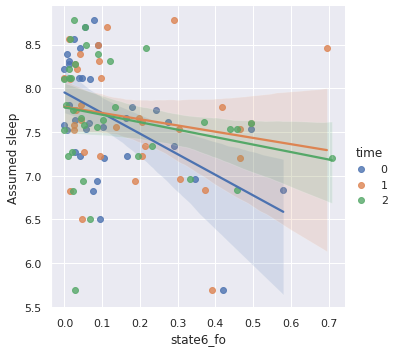

In [51]:
warp_regplot('Assumed sleep')   

In [53]:
fo_beh_conc = pd.concat([fo_beh_list[0],fo_beh_list[1],fo_beh_list[2]]).reset_index(drop=True)
fo_beh_conc

,state1_fo,state2_fo,state3_fo,state4_fo,state5_fo,state6_fo,chrono,time,Category,PER3,...,MSFsc,PSQI,POMS,ESS,DEPRESSION,ANXIETY,STRESS,DASS,BREAKFAST,WD
0,0.124444,0.135556,0.215556,0.142222,0.204444,0.177778,1.0,0,E,44,...,2.48,3,-20.0,3.0,0.0,0.0,2.0,2.0,7.0,7.0
1,0.144444,0.217778,0.224444,0.208889,0.117778,0.086667,1.0,0,E,X,...,2.63,5,14.0,7.0,10.0,0.0,10.0,20.0,7.0,7.0
2,0.260000,0.188889,0.164444,0.242222,0.137778,0.006667,1.0,0,E,45,...,2.42,7,32.0,6.0,14.0,4.0,8.0,26.0,2.0,8.0
3,0.171111,0.184444,0.115556,0.208889,0.157778,0.162222,1.0,0,E,44,...,2.60,3,-3.0,6.0,2.0,2.0,6.0,10.0,7.0,9.0
4,0.217778,0.164444,0.231111,0.186667,0.135556,0.064444,1.0,0,E,45,...,2.33,2,-27.0,2.0,0.0,4.0,0.0,4.0,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.148889,0.191111,0.235556,0.284444,0.140000,0.000000,0.0,2,L,44,...,5.50,9,44.0,7.0,NaN,NaN,NaN,NaN,4.0,10.0
107,0.228889,0.077778,0.220000,0.233333,0.224444,0.015556,0.0,2,L,45,...,9.13,5,-18.0,3.0,2.0,8.0,4.0,14.0,0.0,NaN
108,0.144444,0.117778,0.240000,0.177778,0.124444,0.195556,0.0,2,L,45,...,7.50,4,-5.0,3.0,0.0,0.0,2.0,2.0,2.0,11.0
109,0.184444,0.120000,0.255556,0.248889,0.166667,0.024444,0.0,2,L,44,...,6.75,5,12.0,7.0,6.0,0.0,2.0,8.0,4.0,12.0


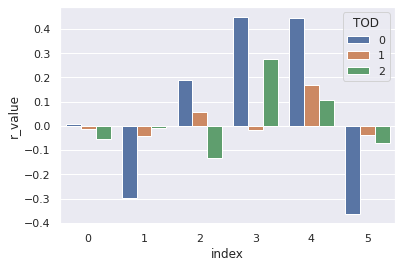

<Figure size 432x288 with 0 Axes>

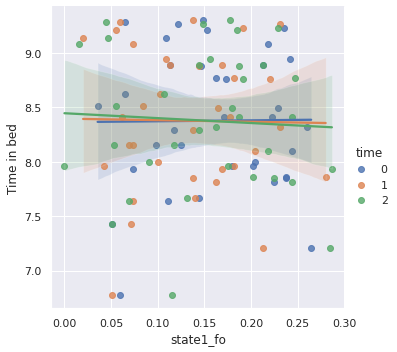

<Figure size 432x288 with 0 Axes>

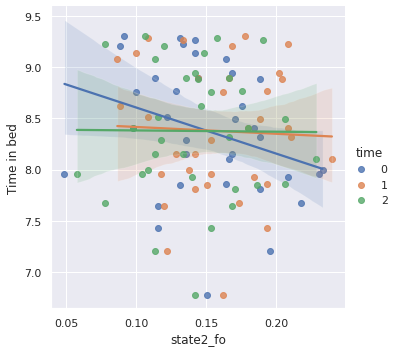

<Figure size 432x288 with 0 Axes>

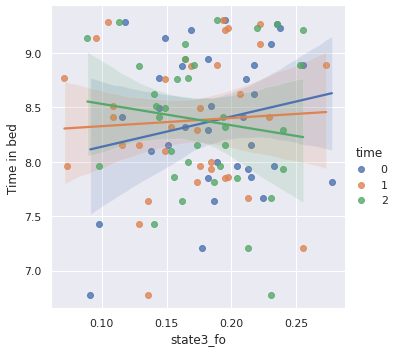

<Figure size 432x288 with 0 Axes>

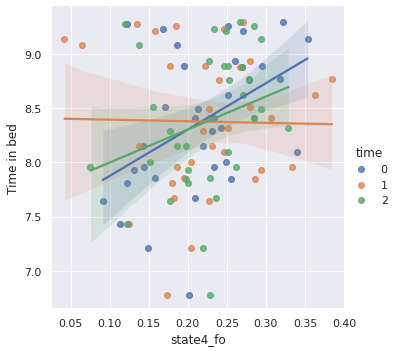

<Figure size 432x288 with 0 Axes>

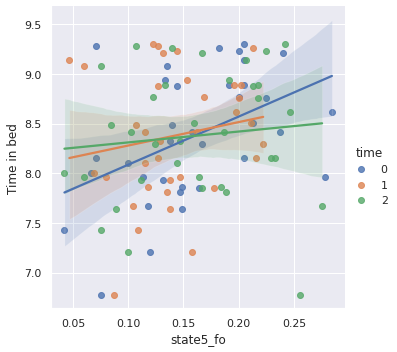

<Figure size 432x288 with 0 Axes>

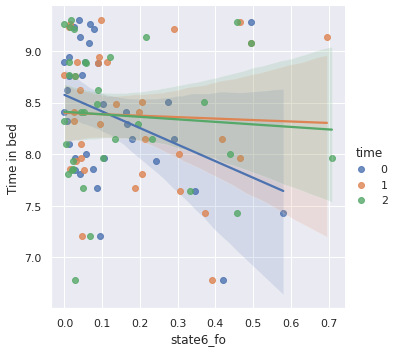

In [54]:
warp_regplot('Time in bed')

### States FO & Actigraph Regplot

* The IV provides an estimate of the fragmentation of the 24-hour rest–activity pattern (IV ≃ 0 for a perfect sine wave, IV ≃ 2 for Gaussian noise). For example, higher IVs could be observed among individuals who often nap during the daytime and are more frequently awake during the night. 
* The IS provides an estimate of how closely the 24-hour rest–activity pattern follows the 24-hour light–dark cycle (IS ≃ 0 for Gaussian noise, IS ≃ 1 for perfect stability). As such, higher IS could indicate good synchronization to light and other environmental cues that regulate the biological clock, assuming the participant was awake during the light cycle and asleep during the dark cycle. 
* The M10 reflects the mean number of active minutes/hour during the 10 hours with the highest activity; thus, a higher M10 represents a more active wake period. The M10 midpoint provides an indication of whether a person is most active earlier or later in the day. 
* In contrast, the L5 reflects the mean number of active minutes/hour during the 5 hours with the lowest activity; thus, a lower L5 indicates more restful sleep. Furthermore, the time of day when L5 occurs (L5 midpoint) provides an indication of whether a person goes to bed earlier or later in the day. 
* Finally, the RA is the difference between M10 and L5 in the average 24-hour pattern, normalized by their sum; higher RAs therefore indicate a more robust 24-hour rest–activity pattern, reflecting both higher activity when awake and relatively lower activity during the night.

ref: Elizabeth M Cespedes Feliciano, ScD, MSc, Mirja Quante, MD, Jia Weng, PhD, Jonathan A Mitchell, PhD, Peter James, Scd, MHS, Catherine R Marinac, PhD, Sara Mariani, PhD, Susan Redline, MD, MPH, Jacqueline Kerr, PhD, Suneeta Godbole, MPH, Alicia Manteiga, MPH, Daniel Wang, J Aaron Hipp, Actigraphy-Derived Daily Rest–Activity Patterns and Body Mass Index in Community-Dwelling Adults, Sleep, Volume 40, Issue 12, December 2017, zsx168, https://doi.org/10.1093/sleep/zsx168

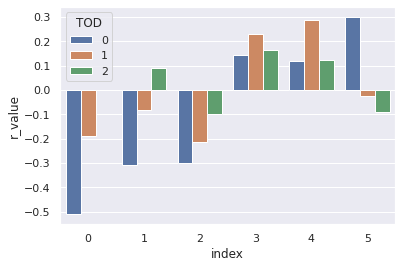

<Figure size 432x288 with 0 Axes>

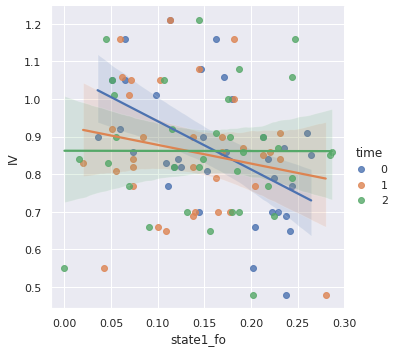

<Figure size 432x288 with 0 Axes>

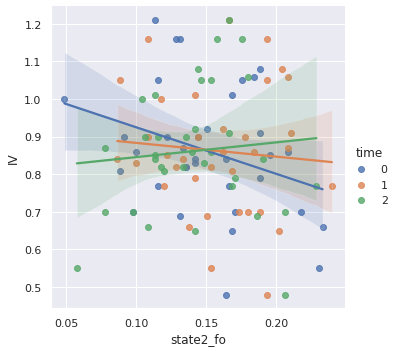

<Figure size 432x288 with 0 Axes>

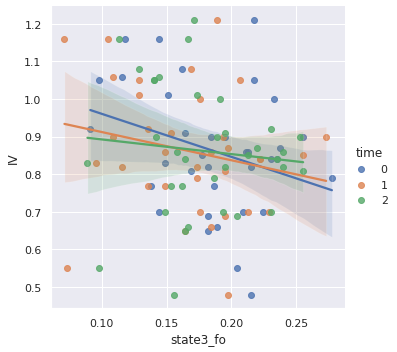

<Figure size 432x288 with 0 Axes>

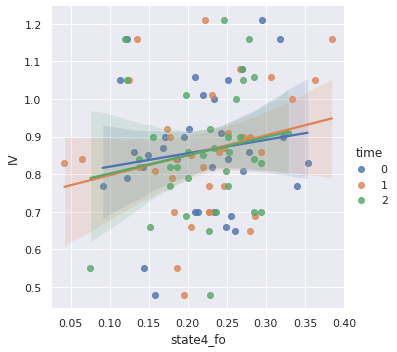

<Figure size 432x288 with 0 Axes>

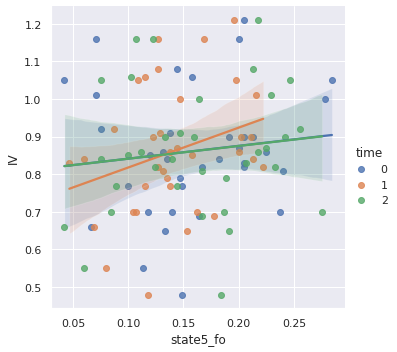

<Figure size 432x288 with 0 Axes>

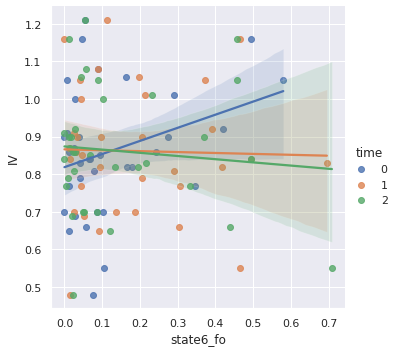

In [55]:
warp_regplot('IV')

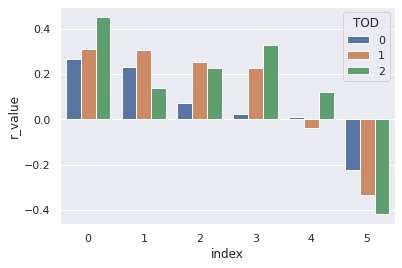

<Figure size 432x288 with 0 Axes>

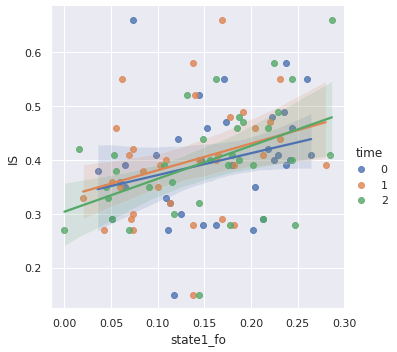

<Figure size 432x288 with 0 Axes>

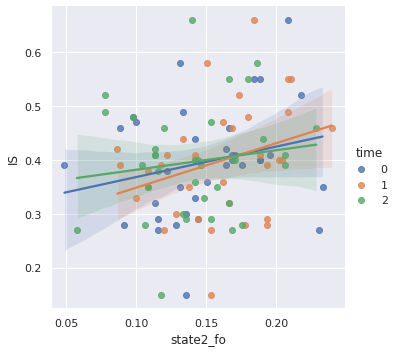

<Figure size 432x288 with 0 Axes>

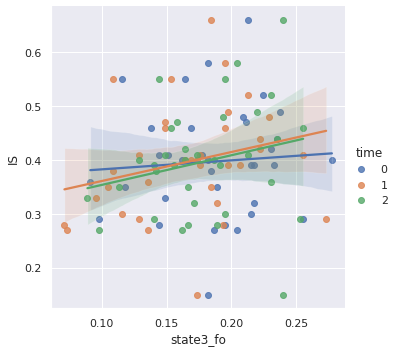

<Figure size 432x288 with 0 Axes>

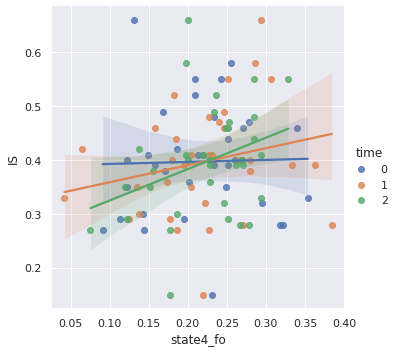

<Figure size 432x288 with 0 Axes>

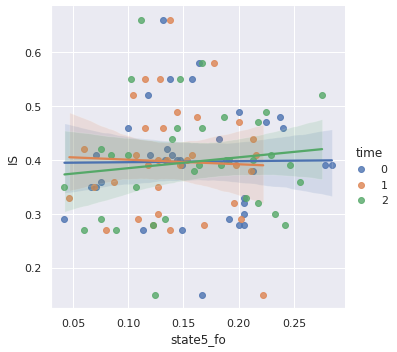

<Figure size 432x288 with 0 Axes>

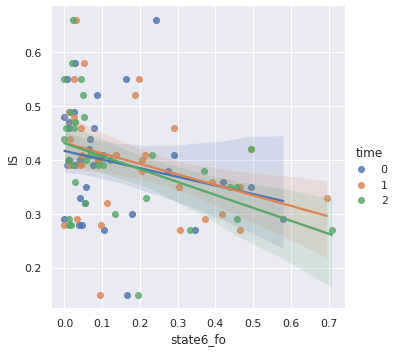

In [56]:
warp_regplot('IS')

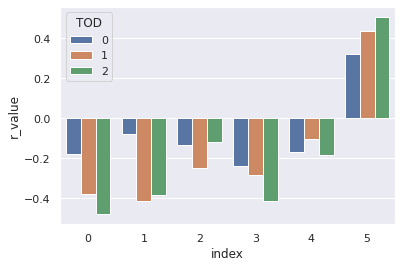

<Figure size 432x288 with 0 Axes>

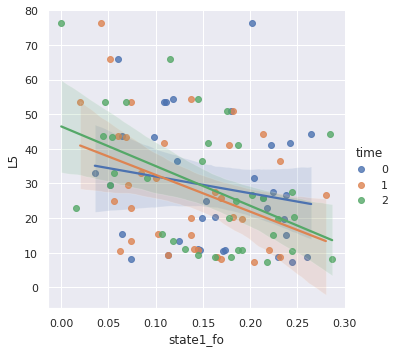

<Figure size 432x288 with 0 Axes>

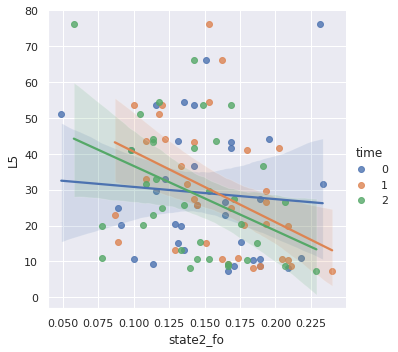

<Figure size 432x288 with 0 Axes>

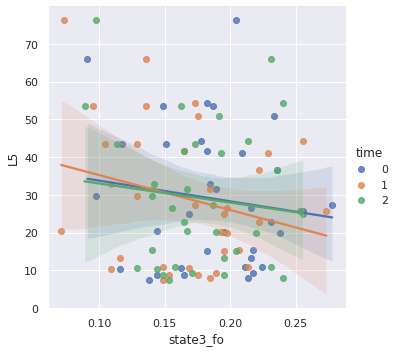

<Figure size 432x288 with 0 Axes>

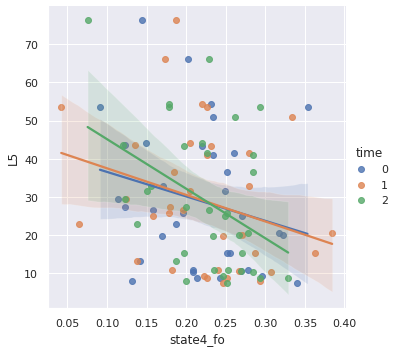

<Figure size 432x288 with 0 Axes>

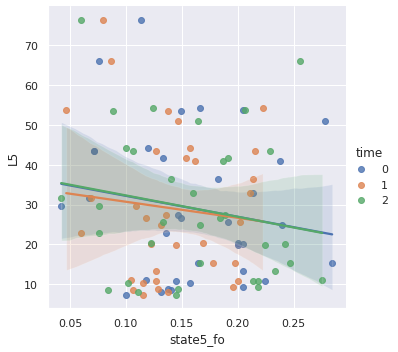

<Figure size 432x288 with 0 Axes>

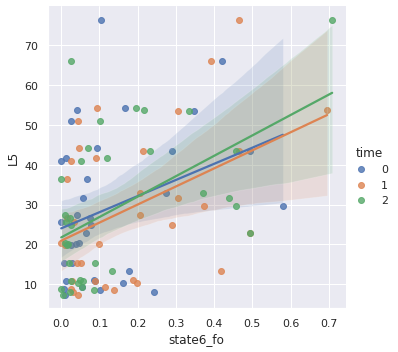

In [57]:
warp_regplot('L5')

In [58]:
fo_beh_list[0].columns

Index(['state1_fo', 'state2_fo', 'state3_fo', 'state4_fo', 'state5_fo',
       'state6_fo', 'chrono', 'time', 'Category', 'PER3', 'DLMO',
       'Phase Angle', 'Peak  Time', 'Peak Conc', 'Cor  Time', 'Cor Conc',
       'CAR %', 'AUC Total', 'AUC 1st Hour', 'Category', 'Days', 'Bed time',
       'Get up time', 'Time in bed', 'Sleep start', 'Sleep end',
       'Assumed sleep', 'Actual sleep time', 'Actual sleep (%)',
       'Actual wake time', 'Actual wake (%)', 'Sleep efficiency',
       'Sleep latency', 'Total activity score', 'Mean activity score',
       'Mean score in active periods', 'Fragmentation index',
       'Avg wake movement', 'IS', 'IV', 'L5', 'L5-onset-phase', 'M10',
       'M10-onset-phase', 'AMP', 'RA', '%OB>IBM', '%IB<OBM', 'Category',
       'Gender', 'Age', 'Handedness ', 'Height', 'Weight', 'Ethnic Origin',
       'MSFsc', 'PSQI', 'POMS', 'ESS', 'DEPRESSION', 'ANXIETY', 'STRESS',
       'DASS', 'BREAKFAST', 'WD'],
      dtype='object')

# Group analysis  


In [59]:
import scipy
from scipy import stats 

random_state = 42

In [60]:
test = True 
test = test & False
test

False

In [61]:
#@title Warp the mean comparison function
def norm_test(group_list, alpha=0.05):
    total_norm=True
    for group in group_list:
        total_norm = total_norm & (stats.shapiro(group)[1]>=0.05)
        if total_norm == False:
            return total_norm
    return total_norm

def compare_mean(df1,df2, K_state):
    mean = []
    for state_index in range(K_state):
        g1=df1.iloc[:, state_index]; g2 = df2.iloc[:, state_index]
        norm = norm_test([g1,g2])
        equal_var = True if stats.levene(g1,g2)[1]>0.05 else False
        if norm:
            mean_comp = stats.ttest_ind(g1, g2, equal_var=equal_var)
        else: 
            mean_comp = stats.mannwhitneyu(g1, g2)
        mean.append([norm, equal_var, mean_comp[0], mean_comp[1]])
    return pd.DataFrame(mean,index=[f"State {i+1}" for i in range(K_state)],
             columns=['normality', 'equal variance', 'stat', 'p value'])


## Two-way Anova

In [64]:
#@title warp twoway_anova
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols
def twoway_anova(fo, K_state, n_rep=1000):
    anova_tables = [] ; Fvalue_table=pd.DataFrame()
    state_list = [ f'State{i}' for i in range(1, K_state+1)]
    for state in state_list:
        model = ols(f"{state} ~ C(chronotype)+ C(time)+ C(chronotype)*C(time)", data=fo).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_tables.append(anova_table)
        Fvalue_table[f"{state}_F"] = anova_table.loc[:,'F']
        Fvalue_table[f"{state}_p"] = anova_table.loc[:,'PR(>F)']
    
    return Fvalue_table, anova_tables 

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
#@title Warp boxplot function
def twoway_boxplot(fo, K_state, subplotformat='23',figsize1=(15,8), title=""):
    subplot_num= K_state
    state_list = [ f'State{i}' for i in range(1, K_state+1)]
    plt.figure(figsize=figsize1)  
    for i in range(len(state_list)):
        state = state_list[i]
        ax = plt.subplot(f'{subplotformat}{i+1}')
        plt.tight_layout()
        sns.boxplot(x="time", y=state, hue="chronotype", data=fo, palette="Set3") 

In [ ]:
# Ordinary Least Squares (OLS) model
# model = ols(f"{state} ~ C(chronotype)+ C(time)+ C(chronotype)*C(time)", data=fo).fit()

Fvalue_table, anova_tables = twoway_anova(fo,K_state)
Fvalue_table

In [ ]:
twoway_boxplot(fo, K_state)

## Chronotype

In [ ]:
ECP = fo[fo['chronotype']==1]; LCP = fo[fo['chronotype']==0] 

In [ ]:
compare_mean(ECP,LCP, K_state)

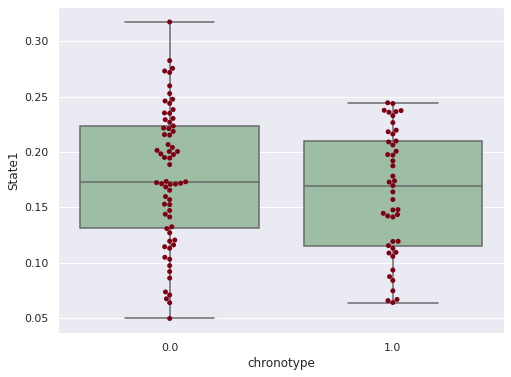

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x='chronotype', y='State1', data=fo, color='#99c2a2')
ax = sns.swarmplot(x='chronotype', y='State1', data=fo, color='#7d0013')

plt.show()

## Time of the day

In [ ]:
#@title warp oneway_anova
def oneway_anova(fo,K_state):
    li = []
    state_list = [ f'State{i}' for i in range(1, K_state+1)]
    for state in state_list:
        m=fo[fo['time']==0][state]
        a=fo[fo['time']==1][state]
        e=fo[fo['time']==2][state]
        li.append(stats.f_oneway(m,a,e))
    return pd.DataFrame(li, index=state_list, columns=['F value', 'p value'])

In [ ]:
oneway_anova(fo, K_state)

,F value,p value
State1,0.882726,0.416617
State2,2.339873,0.101206
State3,0.854382,0.428402
State4,1.590610,0.208538
State5,1.553446,0.216207


In [ ]:
M = ECP = fo[fo['time']==0]; A = fo[fo['time']==1]; E = fo[fo['time']==2] 

In [ ]:
compare_mean(M,A, K_state)

,normality,equal variance,stat,p value
State 1,True,True,1.305994,0.195712
State 2,True,True,1.813440,0.073931
State 3,True,True,1.277350,0.205582
State 4,True,True,-0.971834,0.334387
State 5,False,True,525.000000,0.042815


In [ ]:
compare_mean(A, E, K_state)

,normality,equal variance,stat,p value
State 1,True,True,-1.021951,0.310226
State 2,False,True,502.000000,0.024559
State 3,True,True,-0.778910,0.438585
State 4,True,True,2.016371,0.047492
State 5,False,True,534.000000,0.052442


In [ ]:
compare_mean(M,E, K_state)

,normality,equal variance,stat,p value
State 1,True,True,0.165720,0.868841
State 2,False,True,653.000000,0.368762
State 3,True,True,0.537716,0.592432
State 4,True,True,0.713178,0.478041
State 5,False,True,652.000000,0.364692


# Visualize Markov Chain

In [ ]:
!pip install pyecharts --quiet

In [ ]:
#@title create graph
import numpy as np
P=p_trans
data=[f'state {i}' for i in range(1, K_state+1)]

for i in range(len(data)):
    for j in range(len(data)):
        print("opts.GraphLink(source='%s', target='%s', value=%s),"%(data[i],data[j],P[i][j]))
        

opts.GraphLink(source='state 1', target='state 1', value=0.0),
opts.GraphLink(source='state 1', target='state 2', value=0.246638586334787),
opts.GraphLink(source='state 1', target='state 3', value=0.2028400415390683),
opts.GraphLink(source='state 1', target='state 4', value=0.2813147244712193),
opts.GraphLink(source='state 1', target='state 5', value=0.2692066476549254),
opts.GraphLink(source='state 2', target='state 1', value=0.2134398998714035),
opts.GraphLink(source='state 2', target='state 2', value=0.0),
opts.GraphLink(source='state 2', target='state 3', value=0.3307230945189789),
opts.GraphLink(source='state 2', target='state 4', value=0.1694304478964384),
opts.GraphLink(source='state 2', target='state 5', value=0.28640655771317913),
opts.GraphLink(source='state 3', target='state 1', value=0.2424590821633971),
opts.GraphLink(source='state 3', target='state 2', value=0.269573202549212),
opts.GraphLink(source='state 3', target='state 3', value=0.0),
opts.GraphLink(source='state 3',

In [ ]:
#from snapshot_selenium import snapshot as driver

from pyecharts import options as opts
from pyecharts.charts import Graph
from pyecharts.render import make_snapshot
from pyecharts import options as opts
from pyecharts.charts import Graph

In [ ]:
p_trans.max()

0.3307230945189789

In [ ]:
#@title plot graph
import numpy as np

states = [f"state {i}" for i in range(1, K_state+1) ]
links = []
for i in range(len(data)):
    for j in range(len(data)):
        if p_trans[i][j] > 0:
            links.append(opts.GraphLink(source=states[i], target=states[j], value=round(p_trans[i][j],2)))
        else:
            continue
nodes = [opts.GraphNode(name=f"state {i}", symbol_size=5) for i in range(1, K_state+1)]    

c = (
    Graph()
    .add("", nodes,links,
         edge_symbol=['circle', 'arrow'], 
         repulsion=4000,
         edge_length=0.0001,
         is_draggable=True,
         gravity=0,
         layout="force",
         linestyle_opts=opts.LineStyleOpts(curve=0.5, opacity=0.5),
         edge_label=opts.LabelOpts(
            is_show=True, position="middle", formatter='{c}',  #c就代表value
             font_size=10,
              color='black'
        ),
        )
    .set_global_opts(title_opts=opts.TitleOpts(title="马尔科夫链"))
    .render("graph_with_options.html")
)

# c.render_notebook()


In [ ]:
#@title plot graph
import numpy as np

links = []
for i in range(len(states)):
    index = np.argmax(p_trans[i])
    links.append(opts.GraphLink(source=states[i], target=states[index], value=round(p_trans[i][index],2)))
    index = np.argsort(p_trans[i])[1]
    links.append(opts.GraphLink(source=states[i], target=states[index], value=round(p_trans[i][index],2)))
nodes = [opts.GraphNode(name=f"state {i}", symbol_size=5) for i in range(1, K_state+1)]    

c = (
    Graph()
    .add("", nodes,links,
         edge_symbol=['circle', 'arrow'], 
         repulsion=4000,
         edge_length=0.0001,
         is_draggable=True,
         gravity=0,
         layout="force",
         linestyle_opts=opts.LineStyleOpts(curve=0.1, opacity=0.5),
         edge_label=opts.LabelOpts(
            is_show=True, position="middle", formatter='{c}',  #c就代表value
             font_size=10,
              color='black'
        ),
        )
    .set_global_opts(title_opts=opts.TitleOpts(title="马尔科夫链"))
    .render("max_graph.html")
)

# c.render_notebook()

In [ ]:
from IPython.display import HTML
file = f'max_graph.html'
HTML(filename=file)

In [112]:
get_number_of_visit(lifetime)

,state1_visits,state2_visits,state3_visits,state4_visits,state5_visits,state6_visits
0,10,13,17,11,15,13
1,14,17,17,17,11,7
2,20,16,17,25,14,1
3,13,17,12,16,11,13
4,13,14,15,20,15,5
...,...,...,...,...,...,...
106,12,14,17,22,14,0
107,19,8,15,20,17,3
108,15,8,14,15,10,11
109,15,11,15,24,14,3


,0,1,2,3,4,5
0,5.6,4.692308,5.705882,5.818182,6.133333,6.153846
1,4.642857,5.764706,5.941176,5.529412,4.818182,5.571429
2,5.85,5.3125,4.352941,4.36,4.428571,3.0
3,5.923077,4.882353,4.333333,5.875,6.454545,5.615385
4,7.538462,5.285714,6.933333,4.2,4.066667,5.8
...,...,...,...,...,...,...
106,5.583333,6.142857,6.235294,5.818182,4.5,0
107,5.421053,4.375,6.6,5.25,5.941176,2.333333
108,4.333333,6.625,7.714286,5.333333,5.6,8.0
109,5.533333,4.909091,7.666667,4.666667,5.357143,3.666667
